## Notebook 3  "Filter out least significant features of significant features" 

### Objectives of this notebook
* Iteratively tune Light Gradient Boosting models
* Find most significant features  from data table with significant features to target variable "TARGET" (0 : not defaulted credits ,1 : Credit default)

In [1]:
from sklearn.feature_selection import RFECV
import pandas as pd
import numpy as np
from feature_engine.selection import RecursiveFeatureAddition
import shap
from collections import Counter
import warnings
import scipy
import shap
import joblib
from sklearn import metrics
from scipy.stats import mannwhitneyu, chi2_contingency
from sklearn.metrics import make_scorer, silhouette_score
from sklearn.model_selection import StratifiedKFold,KFold,RandomizedSearchCV
import lightgbm
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
import sweetviz as sv
from IPython.display import display, IFrame,Image
from sklearn.metrics import mean_squared_error, r2_score
from matplotlib import pyplot as plt
import seaborn as sns
import analysis_functions
from IPython.display import display, IFrame
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    recall_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    balanced_accuracy_score,
    f1_score,
)
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")


%matplotlib inline

In [2]:
df_modeling = pd.read_csv("prepared_data/combined_train_df.csv")
df_modeling

SK_ID_CURR  AMT_INCOME_TOTAL  AMT_CREDIT  REGION_POPULATION_RELATIVE  \
0           100002          202500.0    406597.5                    0.018801   
1           100003          270000.0   1293502.5                    0.003541   
2           100004           67500.0    135000.0                    0.010032   
3           100006          135000.0    312682.5                    0.008019   
4           100007          121500.0    513000.0                    0.028663   
...            ...               ...         ...                         ...   
307506      456251          157500.0    254700.0                    0.032561   
307507      456252           72000.0    269550.0                    0.025164   
307508      456253          153000.0    677664.0                    0.005002   
307509      456254          171000.0    370107.0                    0.005313   
307510      456255          157500.0    675000.0                    0.046220   

        DAYS_REGISTRATION  TARGET  CNT_CHILDREN  DAYS_BIRTH  DAYS_ID_PUBLISH  \
0                 -3648.0       1             0       -9461            -2120   
1                 -1186.0       0             0      -16765             -291   
2                 -4260.0       0             0      -19046            -2531   
3                 -9833.0       0             0      -19005            -2437   
4                 -4311.0       0             0      -19932            -3458   
...                   ...     ...           ...         ...              ...   
307506            -8456.0       0             0       -9327            -1982   
307507            -4388.0       0             0      -20775            -4090   
307508            -6737.0       0             0      -14966            -5150   
307509            -2562.0       1             0      -11961             -931   
307510            -5128.0       0             0      -16856             -410   

        FLAG_EMP_PHONE  ...  NAME_YIELD_GROUP_middle_count_HCredit_PApp  \
0                    1  ...                                         0.0   
1                    1  ...                                         2.0   
2                    1  ...                                         1.0   
3                    1  ...                                         1.0   
4                    1  ...                                         3.0   
...                ...  ...                                         ...   
307506               1  ...                                         0.0   
307507               0  ...                                         0.0   
307508               1  ...                                         0.0   
307509               1  ...                                         0.0   
307510               1  ...                                         3.0   

        PRODUCT_COMBINATION_Other_count_HCredit_PApp  \
0                                                1.0   
1                                                2.0   
2                                                1.0   
3                                                6.0   
4                                                4.0   
...                                              ...   
307506                                           0.0   
307507                                           1.0   
307508                                           0.0   
307509                                           0.0   
307510                                           6.0   

        PRODUCT_COMBINATION_POS household with interest_count_HCredit_PApp  \
0                                                     0.0                    
1                                                     1.0                    
2                                                     0.0                    
3                                                     1.0                    
4                                                     1.0                    
...                                         

In [3]:
object_columns = df_modeling.select_dtypes(include=['object']).columns

df_modeling[object_columns] = df_modeling[object_columns].astype('category')
df_main = df_modeling.copy()

## Tuning Light gradient boosting models, for getting shap values (Feature importance)

In [4]:
val_set = df_modeling.sample(frac=0.2, random_state=42)

df_modeling = df_modeling.drop(val_set.index)

In [5]:
feat_to_drop=['TARGET','SK_ID_CURR']

In [6]:
X_val2 = val_set.drop(columns=feat_to_drop,axis=1)
y_val2 = val_set['TARGET']

In [7]:
X = df_modeling.drop(columns=feat_to_drop,axis=1)
y = df_modeling['TARGET']

In [8]:

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3,stratify=y, random_state=42)


baseline_model = LGBMClassifier(
    scale_pos_weight=11,
    objective='binary',
    boosting_type='gbdt',
    metric='auc_pr'
)

baseline_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)], 
)


  File "C:\Users\artur\anaconda3\envs\Stroke\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 13913, number of negative: 158293
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.202615 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6833
[LightGBM] [Info] Number of data points in the train set: 172206, number of used features: 100
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080793 -> initscore=-2.431624
[LightGBM] [Info] Start training from score -2.431624


LGBMClassifier(metric='auc_pr', objective='binary', scale_pos_weight=11)

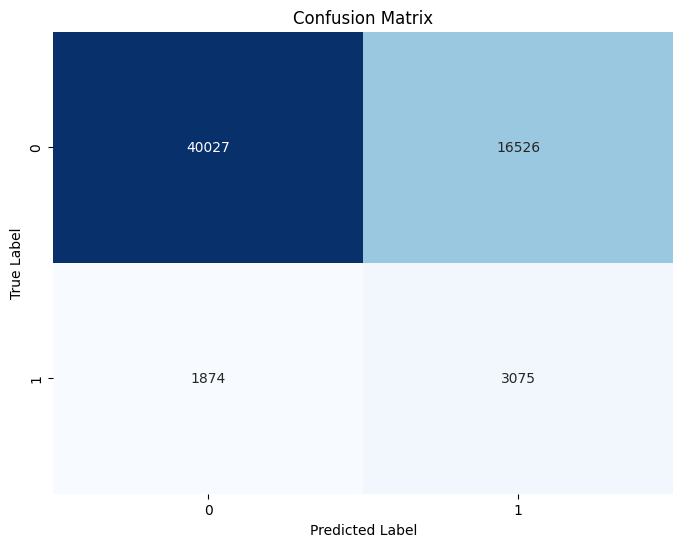

In [9]:
y_pred = baseline_model.predict(X_val2)
conf_matrix = confusion_matrix(y_val2, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [10]:
X_val2

AMT_INCOME_TOTAL  AMT_CREDIT  REGION_POPULATION_RELATIVE  \
245895          207000.0    465457.5                    0.009630   
98194           247500.0   1281712.5                    0.006852   
36463           202500.0    495000.0                    0.035792   
249923          247500.0    254700.0                    0.046220   
158389          112500.0    308133.0                    0.018850   
...                  ...         ...                         ...   
167794          171000.0    521280.0                    0.018634   
256564          450000.0    900000.0                    0.003541   
278889          225000.0    202500.0                    0.028663   
221828          121500.0    254700.0                    0.003818   
190245          112500.0   1314117.0                    0.007120   

        DAYS_REGISTRATION  CNT_CHILDREN  DAYS_BIRTH  DAYS_ID_PUBLISH  \
245895             -637.0             2      -13297            -4307   
98194             -1610.0             0      -14778            -4546   
36463             -2507.0             0      -17907            -1461   
249923           -11167.0             0      -19626            -3158   
158389            -7299.0             0      -20327             -494   
...                   ...           ...         ...              ...   
167794            -3778.0             0      -23793            -5485   
256564            -5335.0             2      -18622            -2153   
278889            -1196.0             0      -12325            -4518   
221828            -2376.0             0      -23629            -4260   
190245            -2618.0             1      -17350             -854   

        FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_PHONE  ...  \
245895               1                0           0  ...   
98194                1                0           0  ...   
36463                1                1           0  ...   
249923               1                0           0  ...   
158389               1                0           0  ...   
...                ...              ...         ...  ...   
167794               0                0           0  ...   
256564               1                0           0  ...   
278889               1                0           0  ...   
221828               0                0           0  ...   
190245               1                0           0  ...   

        NAME_YIELD_GROUP_middle_count_HCredit_PApp  \
245895                                         1.0   
98194                                          4.0   
36463                                          1.0   
249923                                         0.0   
158389                                         0.0   
...                                            ...   
167794                                         5.0   
256564                                         1.0   
278889                                         3.0   
221828                                         1.0   
190245                                         4.0   

        PRODUCT_COMBINATION_Other_count_HCredit_PApp  \
245895                                           3.0   
98194                                            9.0   
36463                                            2.0   
249923                                           0.0   
158389                                           6.0   
...                                              ...   
167794                                          14.0   
256564                                           4.0   
278889                                          11.0   
221828                                           1.0   
190245                                           4.0   

        PRODUCT_COMBINATION_POS household with interest_count_HCredit_PApp  \
245895                                                2.0                    
98194                                                 3.0                    
36463                                            

In [11]:
y_pred = baseline_model.predict(X_val2)

class_report = classification_report(y_val2, y_pred)
print(class_report)

              precision    recall  f1-score   support

           0       0.96      0.71      0.81     56553
           1       0.16      0.62      0.25      4949

    accuracy                           0.70     61502
   macro avg       0.56      0.66      0.53     61502
weighted avg       0.89      0.70      0.77     61502



* XGBOOST classifier baseline model has been created with validation auc:0.71128 
* Model captured corectly 72% of 0 class labels and 59% of 0 class labels

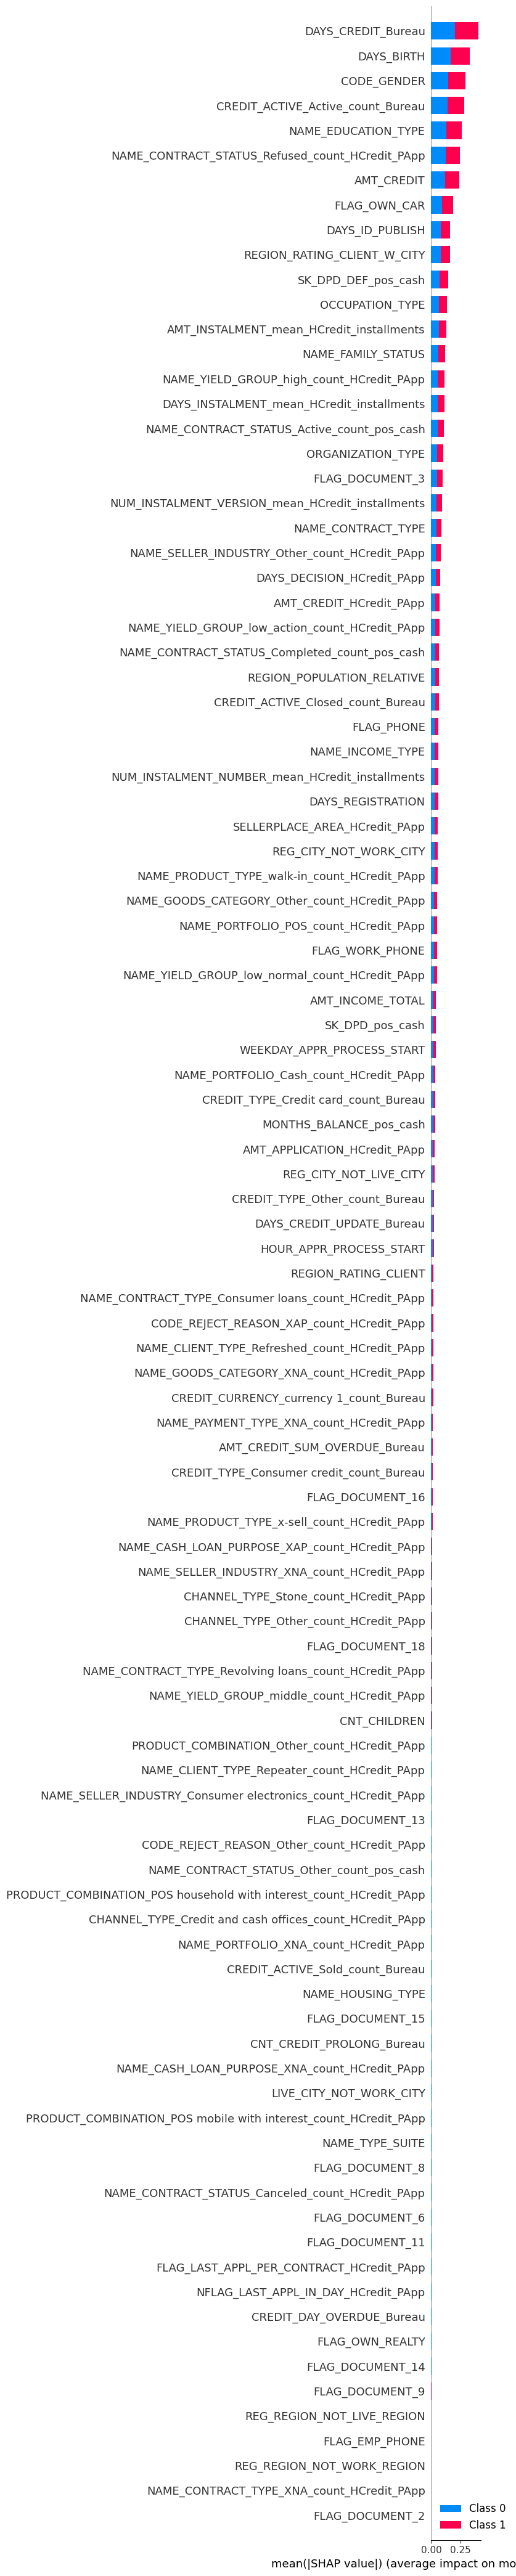

In [12]:
explainer = shap.TreeExplainer(baseline_model)

shap_values = explainer.shap_values(X_val)
shap.initjs()
shap.summary_plot(shap_values, X_val, max_display=len(X_val.columns), plot_type='bar')  # or 'violin' or 'bar'
plt.show()

In [13]:
feature_names = X_train.columns

In [14]:
feature_names

Index(['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'REGION_POPULATION_RELATIVE',
       'DAYS_REGISTRATION', 'CNT_CHILDREN', 'DAYS_BIRTH', 'DAYS_ID_PUBLISH',
       'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_PHONE',
       ...
       'NAME_YIELD_GROUP_middle_count_HCredit_PApp',
       'PRODUCT_COMBINATION_Other_count_HCredit_PApp',
       'PRODUCT_COMBINATION_POS household with interest_count_HCredit_PApp',
       'PRODUCT_COMBINATION_POS mobile with interest_count_HCredit_PApp',
       'AMT_APPLICATION_HCredit_PApp', 'AMT_CREDIT_HCredit_PApp',
       'FLAG_LAST_APPL_PER_CONTRACT_HCredit_PApp',
       'NFLAG_LAST_APPL_IN_DAY_HCredit_PApp', 'DAYS_DECISION_HCredit_PApp',
       'SELLERPLACE_AREA_HCredit_PApp'],
      dtype='object', length=101)

In [15]:
shap_values_abs = np.abs(shap_values[0])

shap_values_abs = pd.DataFrame(shap_values_abs, columns=feature_names)

print("Absolute SHAP values for class 0:")
shap_values_abs

Absolute SHAP values for class 0:


AMT_INCOME_TOTAL  AMT_CREDIT  REGION_POPULATION_RELATIVE  \
0              0.009457    0.152273                    0.084279   
1              0.013333    0.048996                    0.028616   
2              0.032085    0.031011                    0.036427   
3              0.039909    0.141664                    0.031139   
4              0.022935    0.175005                    0.028329   
...                 ...         ...                         ...   
73798          0.001870    0.106547                    0.010378   
73799          0.035278    0.196470                    0.028074   
73800          0.047829    0.126555                    0.026171   
73801          0.009949    0.042118                    0.036516   
73802          0.029789    0.108926                    0.021702   

       DAYS_REGISTRATION  CNT_CHILDREN  DAYS_BIRTH  DAYS_ID_PUBLISH  \
0               0.016300      0.001112    0.283172         0.038979   
1               0.003571      0.003028    0.251985         0.086941   
2               0.012943      0.000123    0.151101         0.062359   
3               0.110131      0.038976    0.004648         0.012898   
4               0.018231      0.001920    0.103225         0.176241   
...                  ...           ...         ...              ...   
73798           0.019887      0.001670    0.116609         0.035765   
73799           0.039077      0.000557    0.198262         0.030715   
73800           0.002996      0.002868    0.032727         0.108257   
73801           0.058989      0.026250    0.121701         0.099764   
73802           0.004281      0.001261    0.185679         0.027045   

       FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_PHONE  ...  \
0                 0.0         0.011040    0.005713  ...   
1                 0.0         0.053959    0.049193  ...   
2                 0.0         0.021381    0.063792  ...   
3                 0.0         0.019826    0.018447  ...   
4                 0.0         0.029244    0.017900  ...   
...               ...              ...         ...  ...   
73798             0.0         0.010021    0.020632  ...   
73799             0.0         0.001406    0.008106  ...   
73800             0.0         0.005538    0.016545  ...   
73801             0.0         0.010233    0.032828  ...   
73802             0.0         0.016394    0.029972  ...   

       NAME_YIELD_GROUP_middle_count_HCredit_PApp  \
0                                        0.001513   
1                                        0.007439   
2                                        0.005624   
3                                        0.001358   
4                                        0.015983   
...                                           ...   
73798                                    0.003097   
73799                                    0.004317   
73800                                    0.002950   
73801                                    0.000534   
73802                                    0.003599   

       PRODUCT_COMBINATION_Other_count_HCredit_PApp  \
0                                          0.000664   
1                                          0.002509   
2                                          0.001350   
3                                          0.000654   
4                                          0.002485   
...                                             ...   
73798                                      0.003608   
73799                                      0.000573   
73800                                      0.001677   
73801                                      0.001167   
73802                                      0.000025   

       PRODUCT_COMBINATION_POS household with interest_count_HCredit_PApp  \
0                                               0.002708                    
1                                               0.000429                    
2                                               0.007577                    
3                                 

In [16]:
mean_shap_values = shap_values_abs.mean(axis=0)
mean_shap_df = pd.DataFrame({'Feature': shap_values_abs.columns, 'Mean_SHAP': mean_shap_values.values})
mean_shap_df = mean_shap_df.sort_values(by='Mean_SHAP', ascending=False)
print(mean_shap_df.head())


                              Feature  Mean_SHAP
48                 DAYS_CREDIT_Bureau   0.202365
5                          DAYS_BIRTH   0.165013
30                        CODE_GENDER   0.146478
41  CREDIT_ACTIVE_Active_count_Bureau   0.141215
35                NAME_EDUCATION_TYPE   0.130331


In [17]:
mean_shap_df.tail(40)

Feature  Mean_SHAP
66      NAME_CASH_LOAN_PURPOSE_XAP_count_HCredit_PApp   0.004586
87        NAME_SELLER_INDUSTRY_XNA_count_HCredit_PApp   0.004491
84              CHANNEL_TYPE_Stone_count_HCredit_PApp   0.004439
83              CHANNEL_TYPE_Other_count_HCredit_PApp   0.004310
28                                   FLAG_DOCUMENT_18   0.004166
64  NAME_CONTRACT_TYPE_Revolving loans_count_HCred...   0.003861
91         NAME_YIELD_GROUP_middle_count_HCredit_PApp   0.003223
4                                        CNT_CHILDREN   0.002814
92       PRODUCT_COMBINATION_Other_count_HCredit_PApp   0.002560
74       NAME_CLIENT_TYPE_Repeater_count_HCredit_PApp   0.002452
85  NAME_SELLER_INDUSTRY_Consumer electronics_coun...   0.002135
24                                   FLAG_DOCUMENT_13   0.002106
71        CODE_REJECT_REASON_Other_count_HCredit_PApp   0.002072
59          NAME_CONTRACT_STATUS_Other_count_pos_cash   0.001968
93  PRODUCT_COMBINATION_POS household with interes...   0.001824
82  CHANNEL_TYPE_Credit and cash offices_count_HCr...   0.001801
79              NAME_PORTFOLIO_XNA_count_HCredit_PApp   0.001775
43                    CREDIT_ACTIVE_Sold_count_Bureau   0.001593
37                                  NAME_HOUSING_TYPE   0.001498
26                                   FLAG_DOCUMENT_15   0.001409
50                          CNT_CREDIT_PROLONG_Bureau   0.001408
67      NAME_CASH_LOAN_PURPOSE_XNA_count_HCredit_PApp   0.001209
17                            LIVE_CITY_NOT_WORK_CITY   0.001180
94  PRODUCT_COMBINATION_POS mobile with interest_c...   0.001135
33                                    NAME_TYPE_SUITE   0.000903
21                                    FLAG_DOCUMENT_8   0.000870
68   NAME_CONTRACT_STATUS_Canceled_count_HCredit_PApp   0.000849
20                                    FLAG_DOCUMENT_6   0.000828
23                                   FLAG_DOCUMENT_11   0.000820
97           FLAG_LAST_APPL_PER_CONTRACT_HCredit_PApp   0.000773
98                NFLAG_LAST_APPL_IN_DAY_HCredit_PApp   0.000717
49                          CREDIT_DAY_OVERDUE_Bureau   0.000583
32                                    FLAG_OWN_REALTY   0.000254
25                                   FLAG_DOCUMENT_14   0.000228
22                                    FLAG_DOCUMENT_9   0.000138
13                         REG_REGION_NOT_LIVE_REGION   0.000000
65          NAME_CONTRACT_TYPE_XNA_count_HCredit_PApp   0.000000
18                                    FLAG_DOCUMENT_2   0.000000
14                         REG_REGION_NOT_WORK_REGION   0.000000
7                                      FLAG_EMP_PHONE   0.000000

# Model performance increasing by eliminating high correlated features 

Check which feature pairs has higher correlation than 70% and than delete feature which has lower feature importance score by baseline LGBOOST Classifier model features shap values.

In [18]:
correlation_matrix = df_modeling.corr()


high_correlation_dict = {}
threshold = 0.7

for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            pair = (correlation_matrix.columns[i], correlation_matrix.columns[j])
            correlation_coef = correlation_matrix.iloc[i, j]
            high_correlation_dict[pair] = correlation_coef




In [19]:
df_corr = pd.DataFrame(list(high_correlation_dict.items()), columns=['Key', 'Value'])

In [20]:
df_corr

Key     Value
0   (REGION_RATING_CLIENT, REGION_RATING_CLIENT_W_...  0.950988
1   (REG_CITY_NOT_WORK_CITY, LIVE_CITY_NOT_WORK_CITY)  0.825126
2   (CREDIT_ACTIVE_Closed_count_Bureau, CREDIT_CUR...  0.923942
3   (CREDIT_ACTIVE_Closed_count_Bureau, CREDIT_TYP...  0.918562
4   (CREDIT_CURRENCY_currency 1_count_Bureau, CRED...  0.932826
..                                                ...       ...
68  (CHANNEL_TYPE_Credit and cash offices_count_HC...  0.948412
69  (CHANNEL_TYPE_Credit and cash offices_count_HC...  0.754673
70  (NAME_SELLER_INDUSTRY_Consumer electronics_cou...  0.808880
71  (NAME_SELLER_INDUSTRY_XNA_count_HCredit_PApp, ...  0.819478
72  (AMT_APPLICATION_HCredit_PApp, AMT_CREDIT_HCre...  0.975665

[73 rows x 2 columns]

In [21]:
df_corr.Value.describe()

count    73.000000
mean      0.824887
std       0.070377
min       0.707701
25%       0.763184
50%       0.817247
75%       0.862922
max       0.975665
Name: Value, dtype: float64

In [22]:
df_corr[['Feature1', 'Feature2']] = pd.DataFrame(df_corr['Key'].tolist(), index=df_corr.index)
df_corr.drop('Key', axis=1, inplace=True)

In [23]:
df = pd.merge(df_corr, mean_shap_df, left_on='Feature1', right_on='Feature', how='left', suffixes=('', '_importance_1'))

In [24]:
df = pd.merge(df, mean_shap_df, left_on='Feature2', right_on='Feature', how='left', suffixes=('', '_importance_2'))

In [25]:
df

Value                                           Feature1  \
0   0.950988                               REGION_RATING_CLIENT   
1   0.825126                             REG_CITY_NOT_WORK_CITY   
2   0.923942                  CREDIT_ACTIVE_Closed_count_Bureau   
3   0.918562                  CREDIT_ACTIVE_Closed_count_Bureau   
4   0.932826            CREDIT_CURRENCY_currency 1_count_Bureau   
..       ...                                                ...   
68  0.948412  CHANNEL_TYPE_Credit and cash offices_count_HCr...   
69  0.754673  CHANNEL_TYPE_Credit and cash offices_count_HCr...   
70  0.808880  NAME_SELLER_INDUSTRY_Consumer electronics_coun...   
71  0.819478        NAME_SELLER_INDUSTRY_XNA_count_HCredit_PApp   
72  0.975665                       AMT_APPLICATION_HCredit_PApp   

                                             Feature2  \
0                         REGION_RATING_CLIENT_W_CITY   
1                             LIVE_CITY_NOT_WORK_CITY   
2             CREDIT_CURRENCY_currency 1_count_Bureau   
3            CREDIT_TYPE_Consumer credit_count_Bureau   
4            CREDIT_TYPE_Consumer credit_count_Bureau   
..                                                ...   
68        NAME_SELLER_INDUSTRY_XNA_count_HCredit_PApp   
69       PRODUCT_COMBINATION_Other_count_HCredit_PApp   
70  PRODUCT_COMBINATION_POS household with interes...   
71       PRODUCT_COMBINATION_Other_count_HCredit_PApp   
72                            AMT_CREDIT_HCredit_PApp   

                                              Feature  Mean_SHAP  \
0                                REGION_RATING_CLIENT   0.009348   
1                              REG_CITY_NOT_WORK_CITY   0.027073   
2                   CREDIT_ACTIVE_Closed_count_Bureau   0.031979   
3                   CREDIT_ACTIVE_Closed_count_Bureau   0.031979   
4             CREDIT_CURRENCY_currency 1_count_Bureau   0.008054   
..                                                ...        ...   
68  CHANNEL_TYPE_Credit and cash offices_count_HCr...   0.001801   
69  CHANNEL_TYPE_Credit and cash offices_count_HCr...   0.001801   
70  NAME_SELLER_INDUSTRY_Consumer electronics_coun...   0.002135   
71        NAME_SELLER_INDUSTRY_XNA_count_HCredit_PApp   0.004491   
72                       AMT_APPLICATION_HCredit_PApp   0.015734   

                                 Feature_importance_2  Mean_SHAP_importance_2  
0                         REGION_RATING_CLIENT_W_CITY                0.079940  
1                             LIVE_CITY_NOT_WORK_CITY                0.001180  
2             CREDIT_CURRENCY_currency 1_count_Bureau                0.008054  
3            CREDIT_TYPE_Consumer credit_count_Bureau                0.007302  
4            CREDIT_TYPE_Consumer credit_count_Bureau                0.007302  
..                                                ...                     ...  
68        NAME_SELLER_INDUSTRY_XNA_count_HCredit_PApp                0.004491  
69       PRODUCT_COMBINATION_Other_count_HCredit_PApp                0.002560  
70  PRODUCT_COMBINATION_POS household with interes...                0.001824  
71       PRODUCT_COMBINATION_Other_count_HCredit_PApp                0.002560  
72                            AMT_CREDIT_HCredit_PApp                0.035435  

[73 rows x 7 columns]

In [26]:
df['features_to_drop'] = df.apply(lambda row: row['Feature2'] if row['Mean_SHAP'] > row['Mean_SHAP_importance_2'] else row['Feature1'], axis=1)

features_to_drop = df['features_to_drop'].unique().tolist()

In [27]:
features_to_drop

['REGION_RATING_CLIENT',
 'LIVE_CITY_NOT_WORK_CITY',
 'CREDIT_CURRENCY_currency 1_count_Bureau',
 'CREDIT_TYPE_Consumer credit_count_Bureau',
 'DAYS_CREDIT_UPDATE_Bureau',
 'MONTHS_BALANCE_pos_cash',
 'DAYS_DECISION_HCredit_PApp',
 'NAME_CASH_LOAN_PURPOSE_XAP_count_HCredit_PApp',
 'NAME_CONTRACT_TYPE_Consumer loans_count_HCredit_PApp',
 'NAME_CONTRACT_STATUS_Canceled_count_HCredit_PApp',
 'NAME_CASH_LOAN_PURPOSE_XNA_count_HCredit_PApp',
 'NAME_PAYMENT_TYPE_XNA_count_HCredit_PApp',
 'NAME_CLIENT_TYPE_Repeater_count_HCredit_PApp',
 'NAME_PORTFOLIO_XNA_count_HCredit_PApp',
 'CHANNEL_TYPE_Credit and cash offices_count_HCredit_PApp',
 'NAME_SELLER_INDUSTRY_XNA_count_HCredit_PApp',
 'NAME_GOODS_CATEGORY_XNA_count_HCredit_PApp',
 'PRODUCT_COMBINATION_Other_count_HCredit_PApp',
 'NAME_PORTFOLIO_POS_count_HCredit_PApp',
 'NAME_SELLER_INDUSTRY_Consumer electronics_count_HCredit_PApp',
 'PRODUCT_COMBINATION_POS household with interest_count_HCredit_PApp',
 'NAME_PRODUCT_TYPE_x-sell_count_HCredit_

In [28]:
len(features_to_drop)

23

Found 24 features which has high correlated pair feature (More than +- 0.6) and we will delete features which has lower feature importance score

In [29]:
X_train = X_train.drop(columns=features_to_drop, axis=1)


In [30]:
X_val = X_val.drop(columns=features_to_drop, axis=1)

In [31]:
X_val2 = X_val2.drop(columns=features_to_drop, axis=1)

# Second model without highly correlated features

In [32]:
LGB_model2 = LGBMClassifier(
    scale_pos_weight=11,
    objective='binary',
    boosting_type='gbdt',
    metric='auc_pr'
)

LGB_model2.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)], 
)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 13913, number of negative: 158293
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.156928 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5192
[LightGBM] [Info] Number of data points in the train set: 172206, number of used features: 77
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080793 -> initscore=-2.431624
[LightGBM] [Info] Start training from score -2.431624


LGBMClassifier(metric='auc_pr', objective='binary', scale_pos_weight=11)

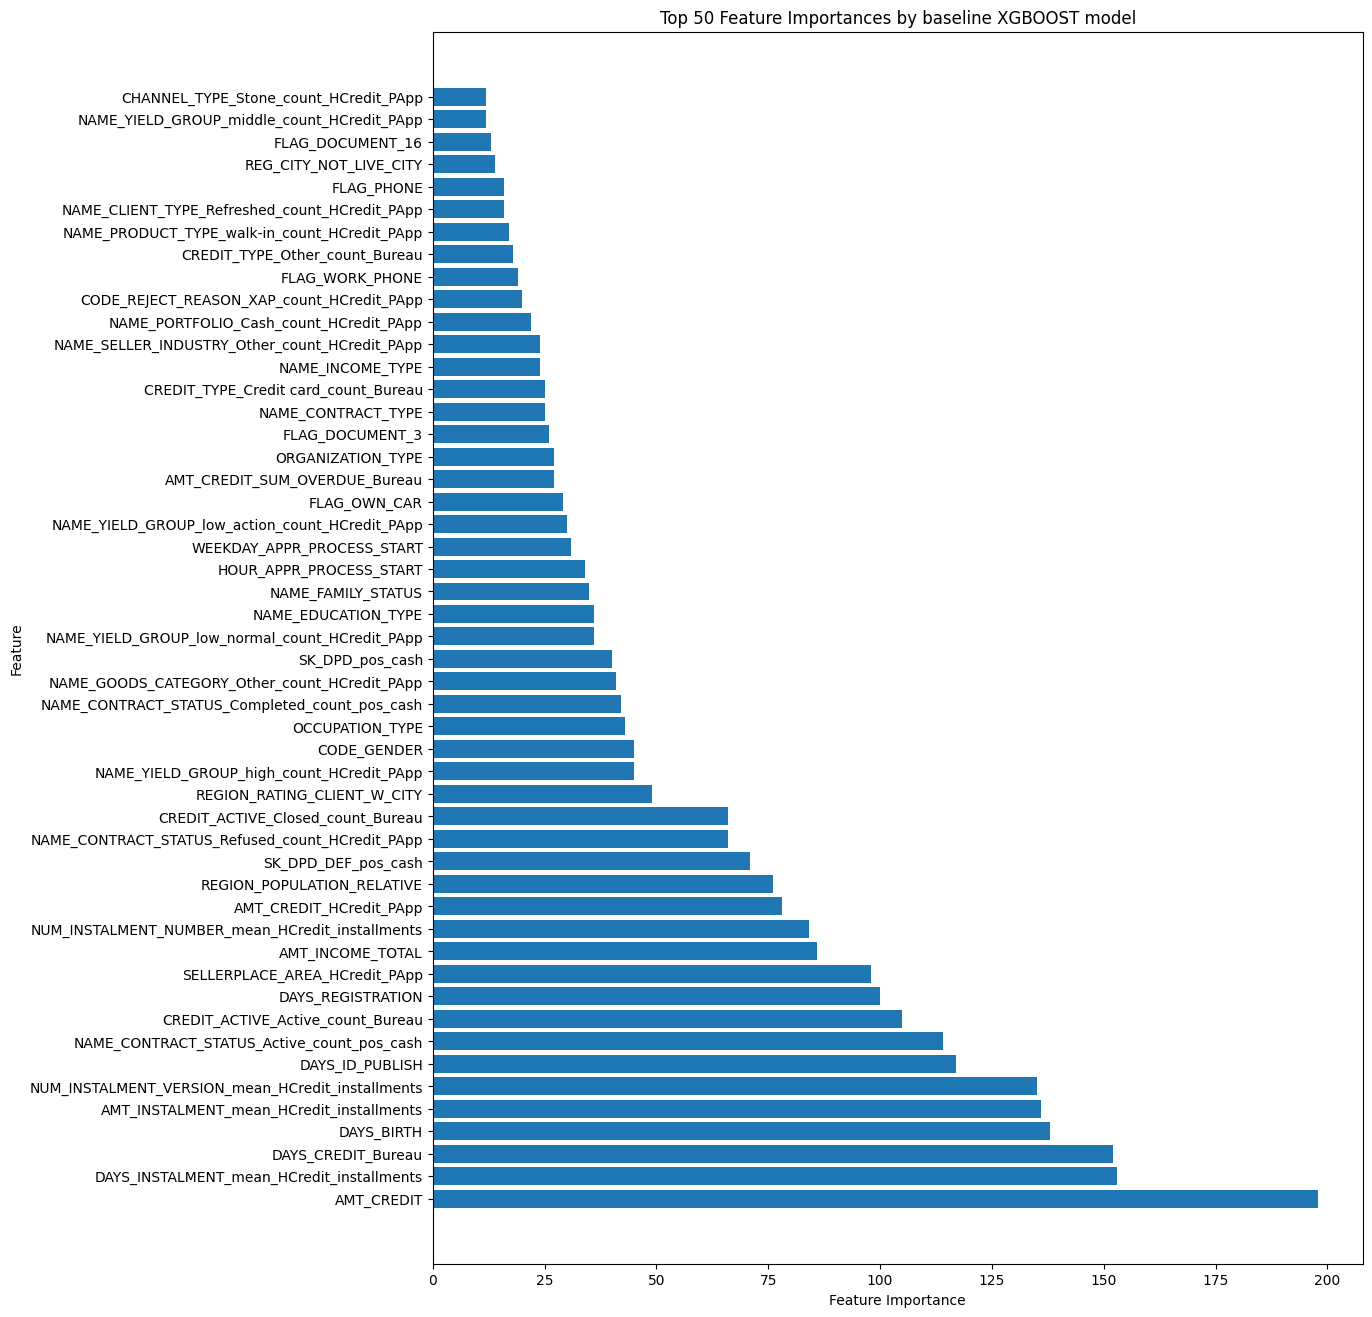

In [33]:
feature_importances = LGB_model2.feature_importances_

# Get feature names
features = X_train.columns

# Create a DataFrame with feature names and their corresponding importances
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the top N feature importances with a larger figsize
top_n = 50
plt.figure(figsize=(12, 16))  # Adjust the figsize as needed
plt.barh(range(top_n), feature_importance_df['Importance'][:top_n], align='center')
plt.yticks(range(top_n), feature_importance_df['Feature'][:top_n])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 50 Feature Importances by baseline XGBOOST model')
plt.show()

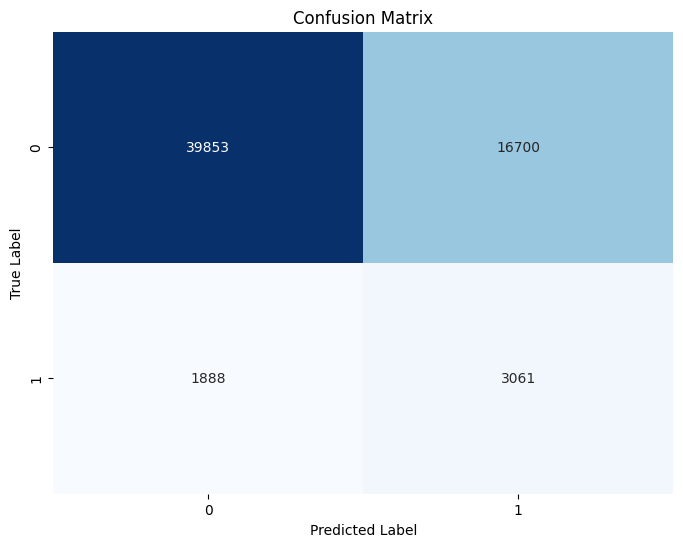

In [34]:
y_pred = LGB_model2.predict(X_val2)
conf_matrix = confusion_matrix(y_val2, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Second model has captured slightly less false positives

In [35]:
y_pred = LGB_model2.predict(X_val2)

# Obtain the classification report
class_report2 = classification_report(y_val2, y_pred)
print(class_report2)

              precision    recall  f1-score   support

           0       0.95      0.70      0.81     56553
           1       0.15      0.62      0.25      4949

    accuracy                           0.70     61502
   macro avg       0.55      0.66      0.53     61502
weighted avg       0.89      0.70      0.77     61502



*  Model captured corectly 71% of 0 class labels and 58% of 0 class labels and identified better 0 class (300 more correct predictions)

In [36]:
X_train

AMT_INCOME_TOTAL  AMT_CREDIT  REGION_POPULATION_RELATIVE  \
124970           49500.0     47970.0                    0.015221   
34610           211500.0   1272888.0                    0.072508   
48003           225000.0    270000.0                    0.004960   
96941           270000.0   1800000.0                    0.005313   
123734           81000.0    212566.5                    0.019101   
...                  ...         ...                         ...   
223904           90000.0    589500.0                    0.010556   
286080          337500.0   1006920.0                    0.072508   
144294          121500.0    227520.0                    0.028663   
122024          189000.0    808650.0                    0.006008   
28272           157500.0    508495.5                    0.002042   

        DAYS_REGISTRATION  CNT_CHILDREN  DAYS_BIRTH  DAYS_ID_PUBLISH  \
124970            -4020.0             0      -15462            -4567   
34610             -7967.0             1      -13858            -5338   
48003             -2996.0             0       -8432            -1092   
96941             -9895.0             0      -21582            -4186   
123734           -13994.0             0      -21712            -4998   
...                   ...           ...         ...              ...   
223904            -2365.0             0      -21039            -2365   
286080            -5665.0             0      -21316            -4644   
144294            -4649.0             2      -10913            -3604   
122024            -6188.0             0      -17757            -1292   
28272              -776.0             3      -12598            -4544   

        FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_PHONE  ...  \
124970               1                1           1  ...   
34610                1                0           0  ...   
48003                1                0           0  ...   
96941                0                0           1  ...   
123734               1                1           1  ...   
...                ...              ...         ...  ...   
223904               1                0           0  ...   
286080               0                0           1  ...   
144294               1                0           0  ...   
122024               1                0           0  ...   
28272                1                0           0  ...   

        NAME_SELLER_INDUSTRY_Other_count_HCredit_PApp  \
124970                                            1.0   
34610                                             1.0   
48003                                             0.0   
96941                                             0.0   
123734                                            1.0   
...                                               ...   
223904                                            0.0   
286080                                            2.0   
144294                                            1.0   
122024                                            0.0   
28272                                             0.0   

        NAME_YIELD_GROUP_high_count_HCredit_PApp  \
124970                                       0.0   
34610                                        0.0   
48003                                        0.0   
96941                                        0.0   
123734                                       1.0   
...                                          ...   
223904                                       0.0   
286080                                       0.0   
144294                                       6.0   
122024                                       2.0   
28272                                        2.0   

        NAME_YIELD_GROUP_low_action_count_HCredit_PApp  \
124970                                             1.0   
34610                                              0.0   
48003                                              0.0   
96941                                              1.0   
12373

In [37]:
explainer2 = shap.TreeExplainer(LGB_model2)
shap_values = explainer2.shap_values(X_val)

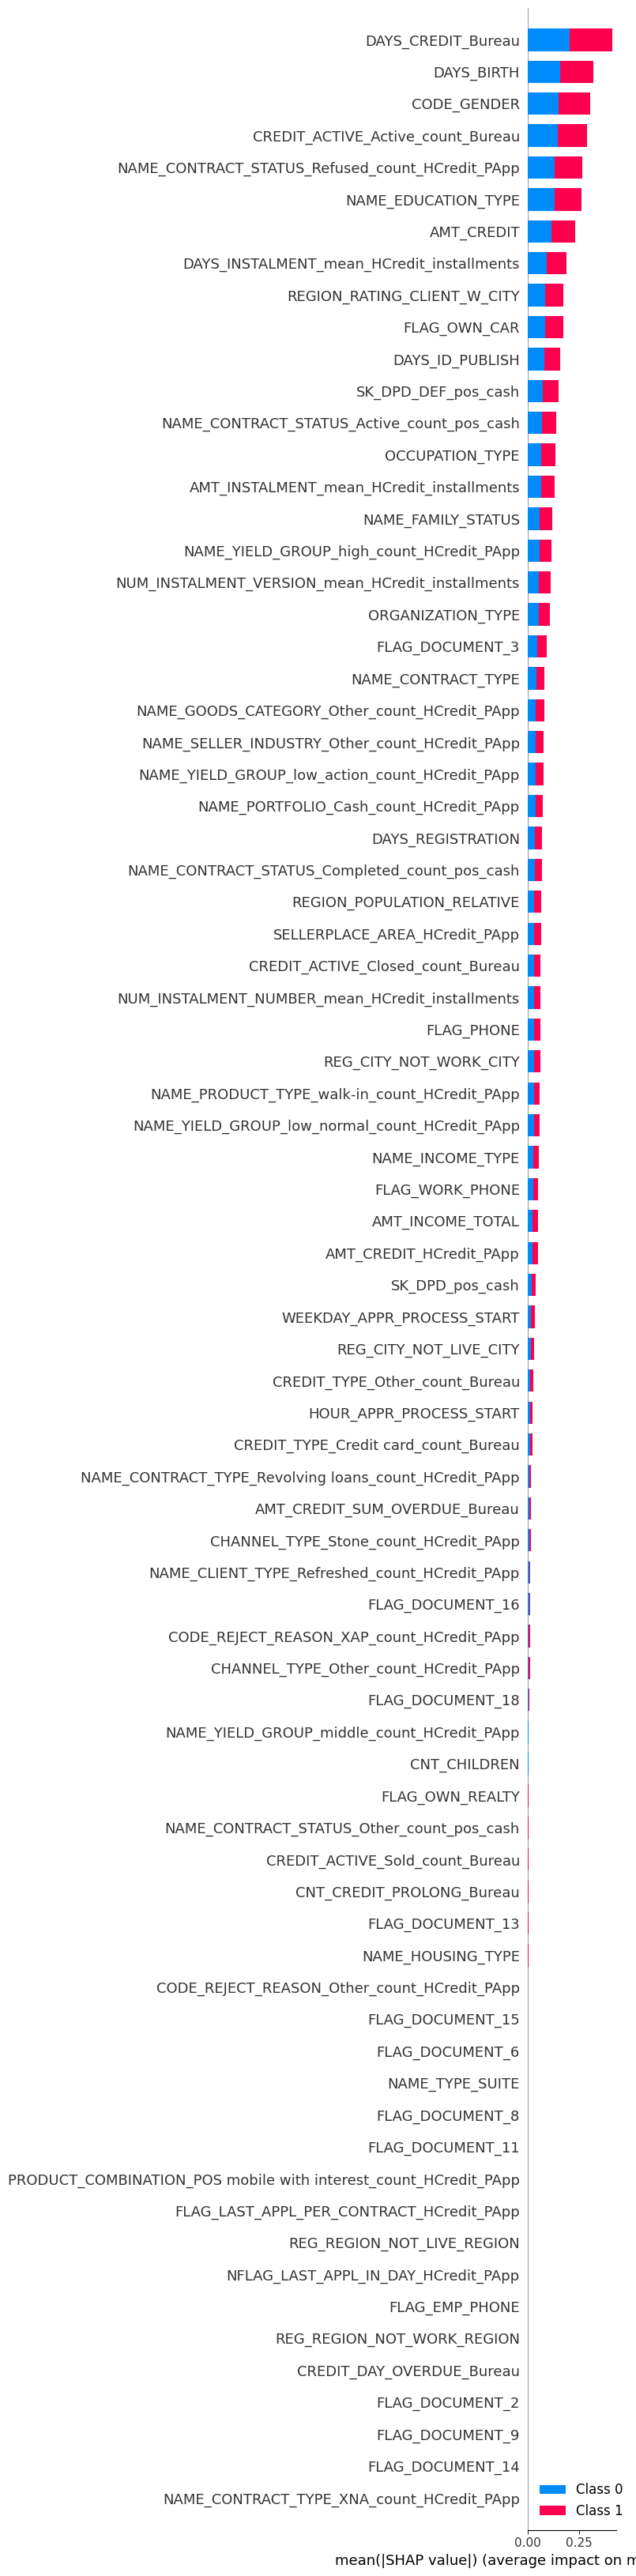

In [38]:
shap.initjs()
shap.summary_plot(shap_values, X_val, max_display=len(X_val.columns), plot_type='bar')  # or 'violin' or 'bar'
plt.show()

In [39]:
feature_names = X_train.columns

In [40]:
shap_values_abs1 = np.abs(shap_values[0])
shap_values_abs1 = pd.DataFrame(shap_values_abs1, columns=feature_names)
print("Absolute SHAP values for class 0:")
shap_values_abs1

Absolute SHAP values for class 0:


AMT_INCOME_TOTAL  AMT_CREDIT  REGION_POPULATION_RELATIVE  \
0              0.035894    0.106984                    0.027774   
1              0.003578    0.047884                    0.033157   
2              0.023995    0.018583                    0.027836   
3              0.101821    0.134988                    0.017782   
4              0.038168    0.236424                    0.014053   
...                 ...         ...                         ...   
73798          0.012302    0.125885                    0.013999   
73799          0.037277    0.093849                    0.018533   
73800          0.091581    0.084157                    0.029505   
73801          0.006401    0.011351                    0.052734   
73802          0.021490    0.190803                    0.026517   

       DAYS_REGISTRATION  CNT_CHILDREN  DAYS_BIRTH  DAYS_ID_PUBLISH  \
0               0.031303      0.000805    0.245476         0.047402   
1               0.009854      0.001208    0.254438         0.091795   
2               0.011164      0.000825    0.132713         0.037589   
3               0.078515      0.049852    0.030662         0.010397   
4               0.067763      0.001159    0.060564         0.156495   
...                  ...           ...         ...              ...   
73798           0.009017      0.000884    0.106063         0.027547   
73799           0.029540      0.000798    0.118964         0.033233   
73800           0.016552      0.000977    0.041189         0.107404   
73801           0.078152      0.014255    0.091195         0.109670   
73802           0.013347      0.002707    0.189352         0.036347   

       FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_PHONE  ...  \
0            0.006692         0.018139    0.022082  ...   
1            0.000202         0.042824    0.085065  ...   
2            0.001935         0.012778    0.042728  ...   
3            0.000181         0.018837    0.014026  ...   
4            0.000182         0.026698    0.021615  ...   
...               ...              ...         ...  ...   
73798        0.005054         0.019882    0.016523  ...   
73799        0.000776         0.003676    0.020414  ...   
73800        0.000293         0.016848    0.015673  ...   
73801        0.000882         0.003931    0.019783  ...   
73802        0.000225         0.019832    0.013596  ...   

       NAME_SELLER_INDUSTRY_Other_count_HCredit_PApp  \
0                                           0.045218   
1                                           0.028032   
2                                           0.017731   
3                                           0.173766   
4                                           0.029385   
...                                              ...   
73798                                       0.021167   
73799                                       0.035485   
73800                                       0.008736   
73801                                       0.032402   
73802                                       0.039366   

       NAME_YIELD_GROUP_high_count_HCredit_PApp  \
0                                      0.088986   
1                                      0.039039   
2                                      0.053853   
3                                      0.008571   
4                                      0.027224   
...                                         ...   
73798                                  0.037764   
73799                                  0.147360   
73800                                  0.001803   
73801                                  0.063125   
73802                                  0.098230   

       NAME_YIELD_GROUP_low_action_count_HCredit_PApp  \
0                                            0.021524   
1                                            0.049486   
2                                            0.117639   
3                                            0.024927   
4                                            0.018927   
...         

In [41]:
mean_shap_values1 = shap_values_abs1.mean(axis=0)
mean_shap_df1 = pd.DataFrame({'Feature': shap_values_abs1.columns, 'Mean_SHAP': mean_shap_values1.values})
mean_shap_df1 = mean_shap_df1.sort_values(by='Mean_SHAP', ascending=False)
print(mean_shap_df1.head())

                                            Feature  Mean_SHAP
44                               DAYS_CREDIT_Bureau   0.206088
5                                        DAYS_BIRTH   0.160021
28                                      CODE_GENDER   0.152275
39                CREDIT_ACTIVE_Active_count_Bureau   0.145924
59  NAME_CONTRACT_STATUS_Refused_count_HCredit_PApp   0.132658


In [42]:
mean_shap_df1.tail(25)

Feature  Mean_SHAP
72         NAME_YIELD_GROUP_middle_count_HCredit_PApp   0.003177
4                                        CNT_CHILDREN   0.003043
30                                    FLAG_OWN_REALTY   0.002641
54          NAME_CONTRACT_STATUS_Other_count_pos_cash   0.002638
41                    CREDIT_ACTIVE_Sold_count_Bureau   0.002384
46                          CNT_CREDIT_PROLONG_Bureau   0.001808
22                                   FLAG_DOCUMENT_13   0.001730
35                                  NAME_HOUSING_TYPE   0.001644
60        CODE_REJECT_REASON_Other_count_HCredit_PApp   0.001489
24                                   FLAG_DOCUMENT_15   0.001431
18                                    FLAG_DOCUMENT_6   0.001359
31                                    NAME_TYPE_SUITE   0.001218
19                                    FLAG_DOCUMENT_8   0.001162
21                                   FLAG_DOCUMENT_11   0.001083
73  PRODUCT_COMBINATION_POS mobile with interest_c...   0.001057
75           FLAG_LAST_APPL_PER_CONTRACT_HCredit_PApp   0.000865
12                         REG_REGION_NOT_LIVE_REGION   0.000860
76                NFLAG_LAST_APPL_IN_DAY_HCredit_PApp   0.000722
7                                      FLAG_EMP_PHONE   0.000714
13                         REG_REGION_NOT_WORK_REGION   0.000573
45                          CREDIT_DAY_OVERDUE_Bureau   0.000275
20                                    FLAG_DOCUMENT_9   0.000000
58          NAME_CONTRACT_TYPE_XNA_count_HCredit_PApp   0.000000
23                                   FLAG_DOCUMENT_14   0.000000
16                                    FLAG_DOCUMENT_2   0.000000

In [43]:
filtered_shap_records2 = mean_shap_df1[mean_shap_df1['Mean_SHAP'] < 0.001]

filtered_shap_records2

Feature  Mean_SHAP
75   FLAG_LAST_APPL_PER_CONTRACT_HCredit_PApp   0.000865
12                 REG_REGION_NOT_LIVE_REGION   0.000860
76        NFLAG_LAST_APPL_IN_DAY_HCredit_PApp   0.000722
7                              FLAG_EMP_PHONE   0.000714
13                 REG_REGION_NOT_WORK_REGION   0.000573
45                  CREDIT_DAY_OVERDUE_Bureau   0.000275
20                            FLAG_DOCUMENT_9   0.000000
58  NAME_CONTRACT_TYPE_XNA_count_HCredit_PApp   0.000000
23                           FLAG_DOCUMENT_14   0.000000
16                            FLAG_DOCUMENT_2   0.000000

In [44]:
features_to_drop2 = filtered_shap_records2.Feature.values

In [45]:
features_to_drop2

array(['FLAG_LAST_APPL_PER_CONTRACT_HCredit_PApp',
       'REG_REGION_NOT_LIVE_REGION',
       'NFLAG_LAST_APPL_IN_DAY_HCredit_PApp', 'FLAG_EMP_PHONE',
       'REG_REGION_NOT_WORK_REGION', 'CREDIT_DAY_OVERDUE_Bureau',
       'FLAG_DOCUMENT_9', 'NAME_CONTRACT_TYPE_XNA_count_HCredit_PApp',
       'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_2'], dtype=object)

In [46]:
X_train

AMT_INCOME_TOTAL  AMT_CREDIT  REGION_POPULATION_RELATIVE  \
124970           49500.0     47970.0                    0.015221   
34610           211500.0   1272888.0                    0.072508   
48003           225000.0    270000.0                    0.004960   
96941           270000.0   1800000.0                    0.005313   
123734           81000.0    212566.5                    0.019101   
...                  ...         ...                         ...   
223904           90000.0    589500.0                    0.010556   
286080          337500.0   1006920.0                    0.072508   
144294          121500.0    227520.0                    0.028663   
122024          189000.0    808650.0                    0.006008   
28272           157500.0    508495.5                    0.002042   

        DAYS_REGISTRATION  CNT_CHILDREN  DAYS_BIRTH  DAYS_ID_PUBLISH  \
124970            -4020.0             0      -15462            -4567   
34610             -7967.0             1      -13858            -5338   
48003             -2996.0             0       -8432            -1092   
96941             -9895.0             0      -21582            -4186   
123734           -13994.0             0      -21712            -4998   
...                   ...           ...         ...              ...   
223904            -2365.0             0      -21039            -2365   
286080            -5665.0             0      -21316            -4644   
144294            -4649.0             2      -10913            -3604   
122024            -6188.0             0      -17757            -1292   
28272              -776.0             3      -12598            -4544   

        FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_PHONE  ...  \
124970               1                1           1  ...   
34610                1                0           0  ...   
48003                1                0           0  ...   
96941                0                0           1  ...   
123734               1                1           1  ...   
...                ...              ...         ...  ...   
223904               1                0           0  ...   
286080               0                0           1  ...   
144294               1                0           0  ...   
122024               1                0           0  ...   
28272                1                0           0  ...   

        NAME_SELLER_INDUSTRY_Other_count_HCredit_PApp  \
124970                                            1.0   
34610                                             1.0   
48003                                             0.0   
96941                                             0.0   
123734                                            1.0   
...                                               ...   
223904                                            0.0   
286080                                            2.0   
144294                                            1.0   
122024                                            0.0   
28272                                             0.0   

        NAME_YIELD_GROUP_high_count_HCredit_PApp  \
124970                                       0.0   
34610                                        0.0   
48003                                        0.0   
96941                                        0.0   
123734                                       1.0   
...                                          ...   
223904                                       0.0   
286080                                       0.0   
144294                                       6.0   
122024                                       2.0   
28272                                        2.0   

        NAME_YIELD_GROUP_low_action_count_HCredit_PApp  \
124970                                             1.0   
34610                                              0.0   
48003                                              0.0   
96941                                              1.0   
12373

In [47]:
X_train

AMT_INCOME_TOTAL  AMT_CREDIT  REGION_POPULATION_RELATIVE  \
124970           49500.0     47970.0                    0.015221   
34610           211500.0   1272888.0                    0.072508   
48003           225000.0    270000.0                    0.004960   
96941           270000.0   1800000.0                    0.005313   
123734           81000.0    212566.5                    0.019101   
...                  ...         ...                         ...   
223904           90000.0    589500.0                    0.010556   
286080          337500.0   1006920.0                    0.072508   
144294          121500.0    227520.0                    0.028663   
122024          189000.0    808650.0                    0.006008   
28272           157500.0    508495.5                    0.002042   

        DAYS_REGISTRATION  CNT_CHILDREN  DAYS_BIRTH  DAYS_ID_PUBLISH  \
124970            -4020.0             0      -15462            -4567   
34610             -7967.0             1      -13858            -5338   
48003             -2996.0             0       -8432            -1092   
96941             -9895.0             0      -21582            -4186   
123734           -13994.0             0      -21712            -4998   
...                   ...           ...         ...              ...   
223904            -2365.0             0      -21039            -2365   
286080            -5665.0             0      -21316            -4644   
144294            -4649.0             2      -10913            -3604   
122024            -6188.0             0      -17757            -1292   
28272              -776.0             3      -12598            -4544   

        FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_PHONE  ...  \
124970               1                1           1  ...   
34610                1                0           0  ...   
48003                1                0           0  ...   
96941                0                0           1  ...   
123734               1                1           1  ...   
...                ...              ...         ...  ...   
223904               1                0           0  ...   
286080               0                0           1  ...   
144294               1                0           0  ...   
122024               1                0           0  ...   
28272                1                0           0  ...   

        NAME_SELLER_INDUSTRY_Other_count_HCredit_PApp  \
124970                                            1.0   
34610                                             1.0   
48003                                             0.0   
96941                                             0.0   
123734                                            1.0   
...                                               ...   
223904                                            0.0   
286080                                            2.0   
144294                                            1.0   
122024                                            0.0   
28272                                             0.0   

        NAME_YIELD_GROUP_high_count_HCredit_PApp  \
124970                                       0.0   
34610                                        0.0   
48003                                        0.0   
96941                                        0.0   
123734                                       1.0   
...                                          ...   
223904                                       0.0   
286080                                       0.0   
144294                                       6.0   
122024                                       2.0   
28272                                        2.0   

        NAME_YIELD_GROUP_low_action_count_HCredit_PApp  \
124970                                             1.0   
34610                                              0.0   
48003                                              0.0   
96941                                              1.0   
12373

In [48]:
X_train =X_train.drop(columns=features_to_drop2,axis=1)

In [49]:
X_val =X_val.drop(columns=features_to_drop2,axis=1)

In [50]:
X_val2 =X_val2.drop(columns=features_to_drop2,axis=1)

In [51]:
LGB_model3 = LGBMClassifier(
    scale_pos_weight=11,
    objective='binary',
    boosting_type='gbdt',
    metric='auc_pr'
)

LGB_model3.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)], 
)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 13913, number of negative: 158293
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.083488 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4797
[LightGBM] [Info] Number of data points in the train set: 172206, number of used features: 68
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080793 -> initscore=-2.431624
[LightGBM] [Info] Start training from score -2.431624


LGBMClassifier(metric='auc_pr', objective='binary', scale_pos_weight=11)

In [52]:
y_pred = LGB_model3.predict(X_val2)

# Obtain the classification report
class_report2 = classification_report(y_val2, y_pred)
print(class_report2)

              precision    recall  f1-score   support

           0       0.96      0.70      0.81     56553
           1       0.16      0.63      0.25      4949

    accuracy                           0.70     61502
   macro avg       0.56      0.66      0.53     61502
weighted avg       0.89      0.70      0.77     61502



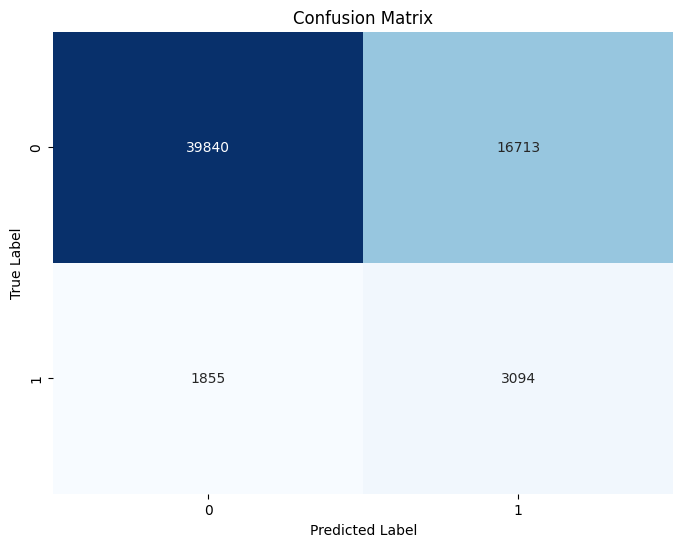

In [53]:
conf_matrix = confusion_matrix(y_val2, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [54]:
explainer3 = shap.TreeExplainer(LGB_model3)
shap_values = explainer3.shap_values(X_val)

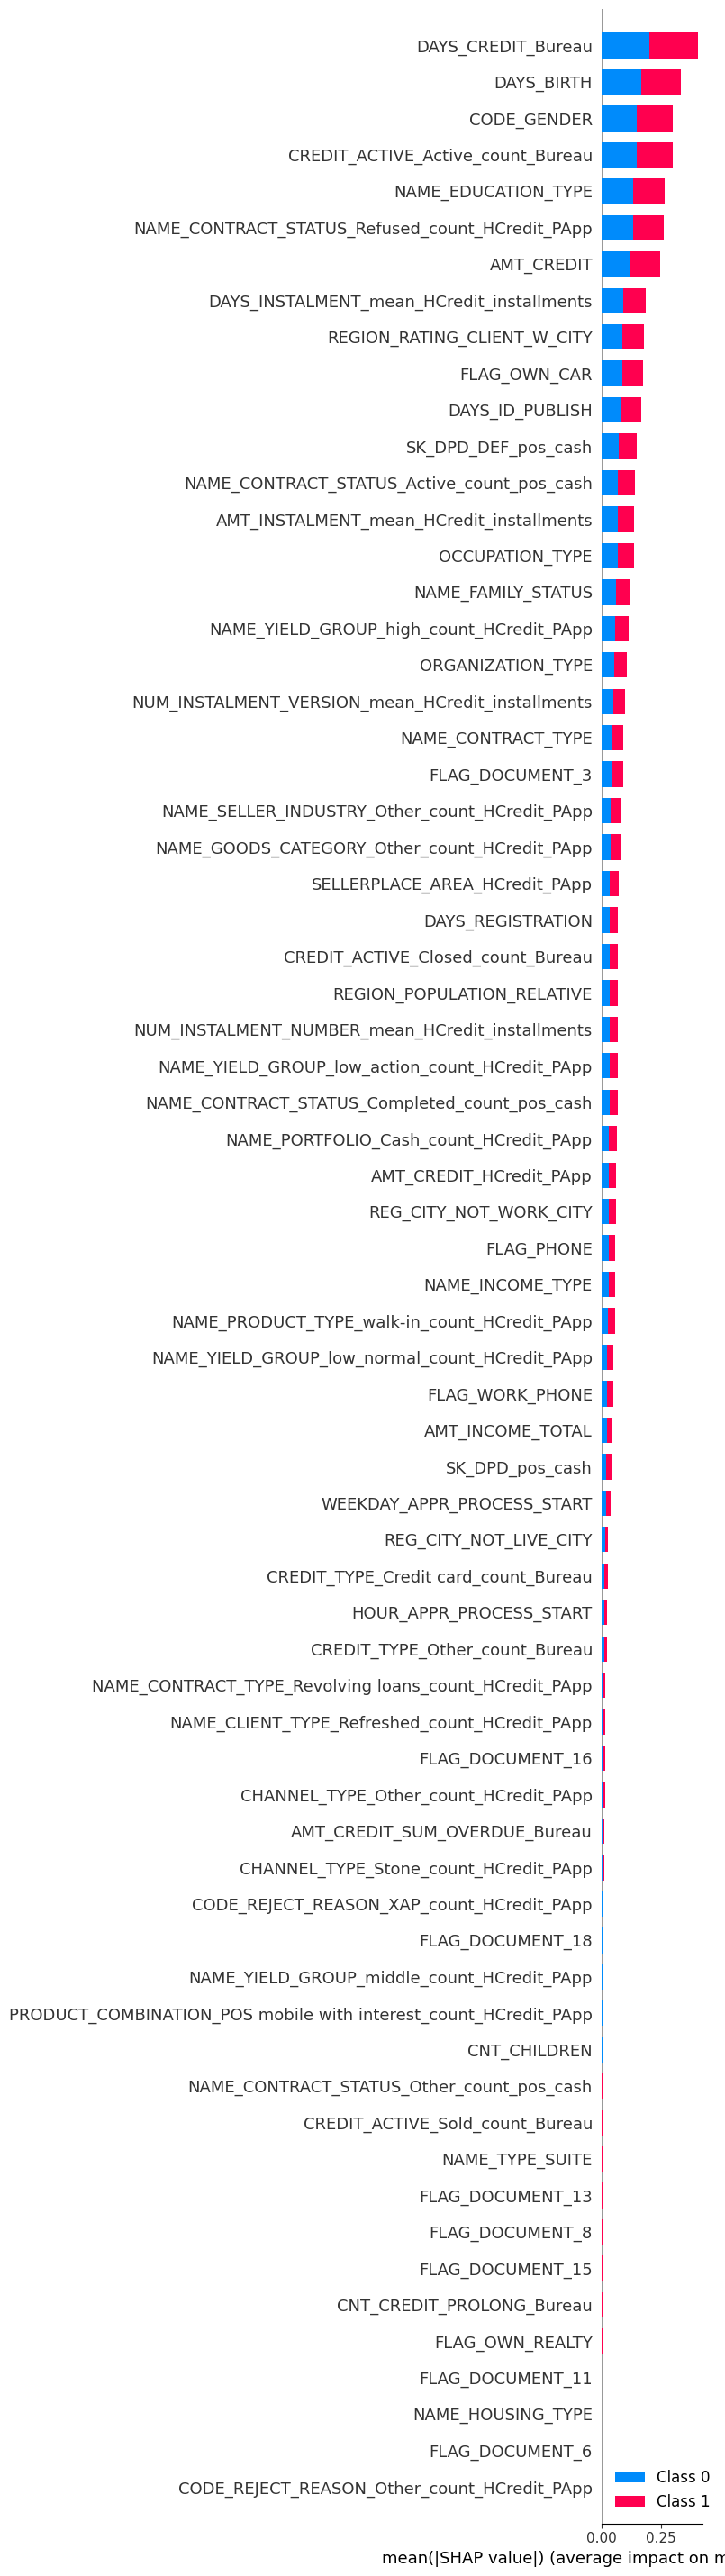

In [55]:
shap.initjs()
shap.summary_plot(shap_values, X_val, max_display=len(X_val.columns), plot_type='bar')  # or 'violin' or 'bar'
plt.show()

In [56]:
feature_names = X_train.columns

In [57]:
shap_values_abs2 = np.abs(shap_values[0])
shap_values_abs2 = pd.DataFrame(shap_values_abs2, columns=feature_names)
print("Absolute SHAP values for class 0:")
shap_values_abs2

Absolute SHAP values for class 0:


AMT_INCOME_TOTAL  AMT_CREDIT  REGION_POPULATION_RELATIVE  \
0              0.023009    0.098908                    0.000579   
1              0.003394    0.072596                    0.038518   
2              0.035654    0.023944                    0.051551   
3              0.079002    0.138385                    0.008571   
4              0.023186    0.231185                    0.013138   
...                 ...         ...                         ...   
73798          0.022443    0.148832                    0.011876   
73799          0.025235    0.134241                    0.055126   
73800          0.097928    0.094357                    0.068683   
73801          0.008632    0.004073                    0.048223   
73802          0.019938    0.167718                    0.059066   

       DAYS_REGISTRATION  CNT_CHILDREN  DAYS_BIRTH  DAYS_ID_PUBLISH  \
0               0.016940      0.002356    0.291456         0.057474   
1               0.008844      0.001302    0.216014         0.109440   
2               0.014008      0.000713    0.106673         0.016051   
3               0.069844      0.035881    0.103675         0.012880   
4               0.072121      0.001267    0.071948         0.175235   
...                  ...           ...         ...              ...   
73798           0.002016      0.001310    0.107969         0.025809   
73799           0.017996      0.000714    0.155914         0.034273   
73800           0.009080      0.000768    0.054503         0.108376   
73801           0.085600      0.022041    0.092921         0.129021   
73802           0.001830      0.001448    0.197876         0.024255   

       FLAG_WORK_PHONE  FLAG_PHONE  REGION_RATING_CLIENT_W_CITY  ...  \
0             0.029913    0.026243                     0.019071  ...   
1             0.039143    0.063532                     0.021958  ...   
2             0.013599    0.053173                     0.020998  ...   
3             0.022970    0.011658                     0.291683  ...   
4             0.024032    0.017872                     0.361036  ...   
...                ...         ...                          ...  ...   
73798         0.017179    0.020849                     0.012032  ...   
73799         0.009947    0.018612                     0.112403  ...   
73800         0.002452    0.013970                     0.193108  ...   
73801         0.005530    0.020689                     0.023917  ...   
73802         0.023223    0.012126                     0.029712  ...   

       CHANNEL_TYPE_Other_count_HCredit_PApp  \
0                                   0.001175   
1                                   0.002411   
2                                   0.001174   
3                                   0.001128   
4                                   0.001431   
...                                      ...   
73798                               0.003645   
73799                               0.025635   
73800                               0.039421   
73801                               0.002043   
73802                               0.003758   

       CHANNEL_TYPE_Stone_count_HCredit_PApp  \
0                                   0.001328   
1                                   0.011172   
2                                   0.001333   
3                                   0.003488   
4                                   0.011572   
...                                      ...   
73798                               0.012373   
73799                               0.001869   
73800                               0.003757   
73801                               0.004572   
73802                               0.001791   

       NAME_SELLER_INDUSTRY_Other_count_HCredit_PApp  \
0                                           0.050386   
1                                           0.040353   
2                                           0.016397   
3                                           0.101565   
4                                           0.0290

In [58]:
mean_shap_values2 = shap_values_abs2.mean(axis=0)
mean_shap_df2 = pd.DataFrame({'Feature': shap_values_abs2.columns, 'Mean_SHAP': mean_shap_values2.values})
mean_shap_df2 = mean_shap_df2.sort_values(by='Mean_SHAP', ascending=False)
print(mean_shap_df2.head())

                              Feature  Mean_SHAP
38                 DAYS_CREDIT_Bureau   0.202345
5                          DAYS_BIRTH   0.166374
22                        CODE_GENDER   0.150183
33  CREDIT_ACTIVE_Active_count_Bureau   0.149977
27                NAME_EDUCATION_TYPE   0.132610


In [59]:
features_to_drop3 = mean_shap_df2.tail(20).Feature.values

In [60]:
X_train = X_train.drop(columns=features_to_drop3,axis=1)
X_val = X_val.drop(columns=features_to_drop3,axis=1)
X_val2 = X_val2.drop(columns=features_to_drop3,axis=1)

In [61]:
LGB_model4 = LGBMClassifier(
    scale_pos_weight=11,
    objective='binary',
    boosting_type='gbdt',
    metric='auc_pr'
)

LGB_model4.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)], 
)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 13913, number of negative: 158293
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.053144 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4254
[LightGBM] [Info] Number of data points in the train set: 172206, number of used features: 48
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080793 -> initscore=-2.431624
[LightGBM] [Info] Start training from score -2.431624


LGBMClassifier(metric='auc_pr', objective='binary', scale_pos_weight=11)

In [62]:
y_pred = LGB_model4.predict(X_val2)
class_report4 = classification_report(y_val2, y_pred)
print(class_report4)

              precision    recall  f1-score   support

           0       0.95      0.70      0.81     56553
           1       0.15      0.62      0.25      4949

    accuracy                           0.70     61502
   macro avg       0.55      0.66      0.53     61502
weighted avg       0.89      0.70      0.76     61502



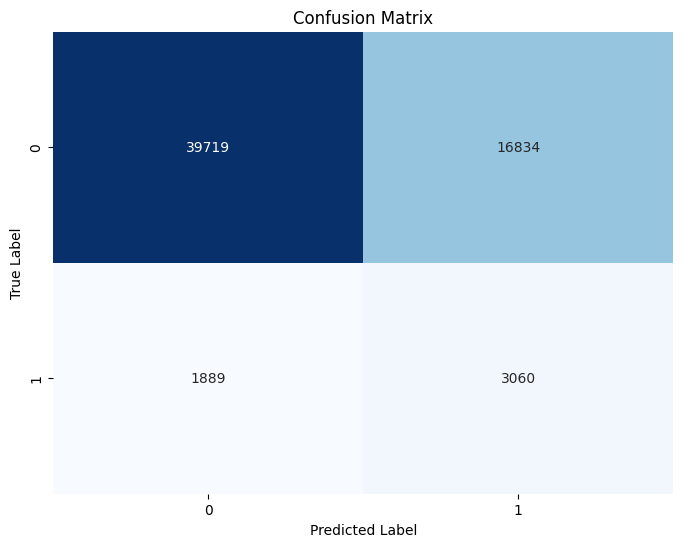

In [63]:
conf_matrix = confusion_matrix(y_val2, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

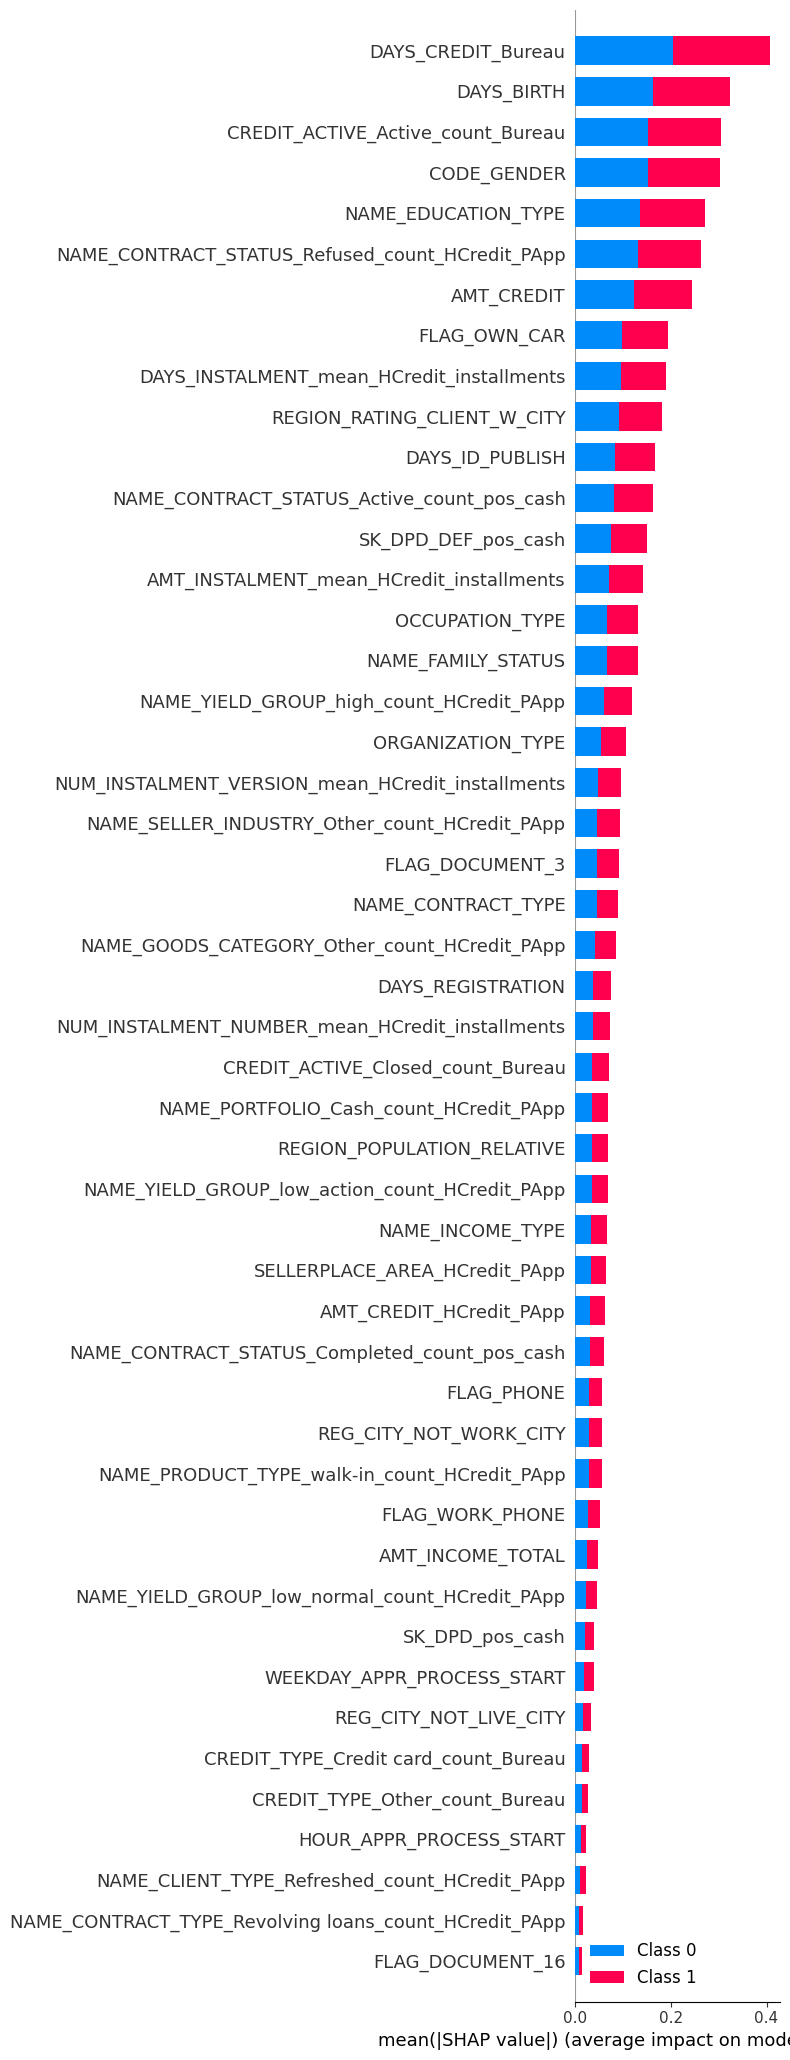

In [64]:
explainer4 = shap.TreeExplainer(LGB_model4)
shap_values = explainer4.shap_values(X_val)
shap.initjs()
shap.summary_plot(shap_values, X_val, max_display=len(X_val.columns), plot_type='bar') 
plt.show()

In [65]:
feature_names = X_train.columns
shap_values_abs4= np.abs(shap_values[0])

shap_values_abs4 = pd.DataFrame(shap_values_abs4, columns=feature_names)

print("Absolute SHAP values for class 0:")
shap_values_abs4

Absolute SHAP values for class 0:


AMT_INCOME_TOTAL  AMT_CREDIT  REGION_POPULATION_RELATIVE  \
0              0.057045    0.131924                    0.012791   
1              0.010680    0.041608                    0.031159   
2              0.018363    0.012894                    0.049523   
3              0.095295    0.164234                    0.027009   
4              0.044491    0.208237                    0.014365   
...                 ...         ...                         ...   
73798          0.004971    0.171395                    0.008006   
73799          0.009632    0.096937                    0.025031   
73800          0.101080    0.103703                    0.048469   
73801          0.007831    0.015620                    0.027737   
73802          0.012330    0.142134                    0.069615   

       DAYS_REGISTRATION  DAYS_BIRTH  DAYS_ID_PUBLISH  FLAG_WORK_PHONE  \
0               0.013204    0.289454         0.094171         0.022784   
1               0.011898    0.244075         0.081701         0.058334   
2               0.005437    0.123775         0.045396         0.011599   
3               0.093485    0.030167         0.010695         0.011721   
4               0.080858    0.072397         0.171866         0.029969   
...                  ...         ...              ...              ...   
73798           0.012237    0.098798         0.005713         0.018644   
73799           0.030571    0.137461         0.033221         0.016193   
73800           0.025939    0.041896         0.115441         0.011204   
73801           0.118519    0.097263         0.101579         0.011018   
73802           0.019871    0.193413         0.002107         0.021398   

       FLAG_PHONE  REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  ...  \
0        0.013145                     0.020230                 0.003333  ...   
1        0.081612                     0.026740                 0.054057  ...   
2        0.049444                     0.011835                 0.001224  ...   
3        0.025378                     0.302437                 0.033425  ...   
4        0.024553                     0.390967                 0.003121  ...   
...           ...                          ...                      ...  ...   
73798    0.019142                     0.010627                 0.003763  ...   
73799    0.009491                     0.219858                 0.012800  ...   
73800    0.018425                     0.183027                 0.008453  ...   
73801    0.020923                     0.013682                 0.000103  ...   
73802    0.011099                     0.034951                 0.004332  ...   

       NAME_CLIENT_TYPE_Refreshed_count_HCredit_PApp  \
0                                           0.004637   
1                                           0.004063   
2                                           0.002625   
3                                           0.025284   
4                                           0.001557   
...                                              ...   
73798                                       0.030358   
73799                                       0.008827   
73800                                       0.005422   
73801                                       0.032375   
73802                                       0.009552   

       NAME_GOODS_CATEGORY_Other_count_HCredit_PApp  \
0                                          0.019477   
1                                          0.106460   
2                                          0.199600   
3                                          0.004079   
4                                          0.050953   
...                                             ...   
73798                                      0.098138   
73799                                      0.133152   
73800                                      0.002738   
73801                                      0.024022   
73802                                      0.017445   

       NAME_PORTFO

In [66]:
mean_shap_values4 = shap_values_abs4.mean(axis=0)
mean_shap_df4 = pd.DataFrame({'Feature': shap_values_abs4.columns, 'Mean_SHAP': mean_shap_values4.values})
mean_shap_df4 = mean_shap_df4.sort_values(by='Mean_SHAP', ascending=False)
print(mean_shap_df4.tail(20))

                                              Feature  Mean_SHAP
44     NAME_YIELD_GROUP_low_action_count_HCredit_PApp   0.034097
17                                   NAME_INCOME_TYPE   0.033353
47                      SELLERPLACE_AREA_HCredit_PApp   0.031795
46                            AMT_CREDIT_HCredit_PApp   0.031343
33      NAME_CONTRACT_STATUS_Completed_count_pos_cash   0.029963
7                                          FLAG_PHONE   0.028398
11                             REG_CITY_NOT_WORK_CITY   0.028047
41       NAME_PRODUCT_TYPE_walk-in_count_HCredit_PApp   0.027719
6                                     FLAG_WORK_PHONE   0.025644
0                                    AMT_INCOME_TOTAL   0.023791
45     NAME_YIELD_GROUP_low_normal_count_HCredit_PApp   0.022943
34                                    SK_DPD_pos_cash   0.019184
21                         WEEKDAY_APPR_PROCESS_START   0.018998
10                             REG_CITY_NOT_LIVE_CITY   0.015910
25               CREDIT_T

In [67]:
features_to_drop4 = mean_shap_df4.tail(10).Feature.values

In [68]:
X_train = X_train.drop(columns=features_to_drop4,axis=1)
X_val = X_val.drop(columns=features_to_drop4,axis=1)
X_val2 = X_val2.drop(columns=features_to_drop4,axis=1)

In [69]:
LGB_model5 = LGBMClassifier(
    scale_pos_weight=11,
    objective='binary',
    boosting_type='gbdt',
    metric='auc_pr'
)

LGB_model5.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)], 
)

[LightGBM] [Info] Number of positive: 13913, number of negative: 158293
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.046396 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3853
[LightGBM] [Info] Number of data points in the train set: 172206, number of used features: 38
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080793 -> initscore=-2.431624
[LightGBM] [Info] Start training from score -2.431624


LGBMClassifier(metric='auc_pr', objective='binary', scale_pos_weight=11)

In [70]:
y_pred = LGB_model5.predict(X_val2)

class_report5 = classification_report(y_val2, y_pred)
print(class_report5)

              precision    recall  f1-score   support

           0       0.95      0.70      0.81     56553
           1       0.15      0.62      0.25      4949

    accuracy                           0.70     61502
   macro avg       0.55      0.66      0.53     61502
weighted avg       0.89      0.70      0.76     61502



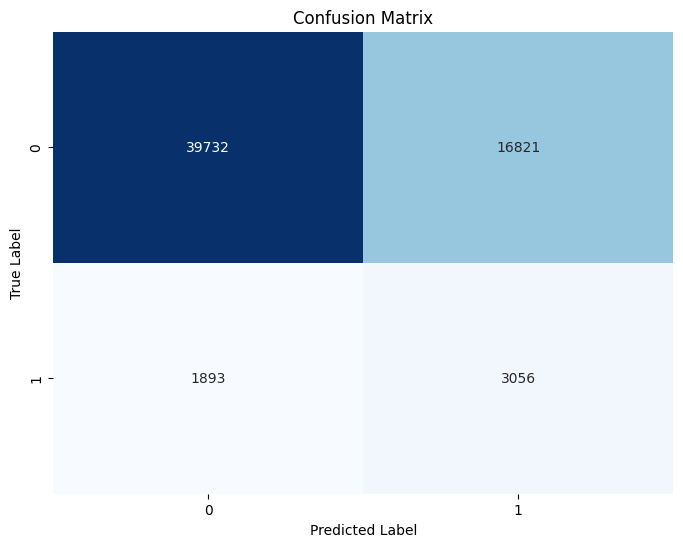

In [71]:
conf_matrix = confusion_matrix(y_val2, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

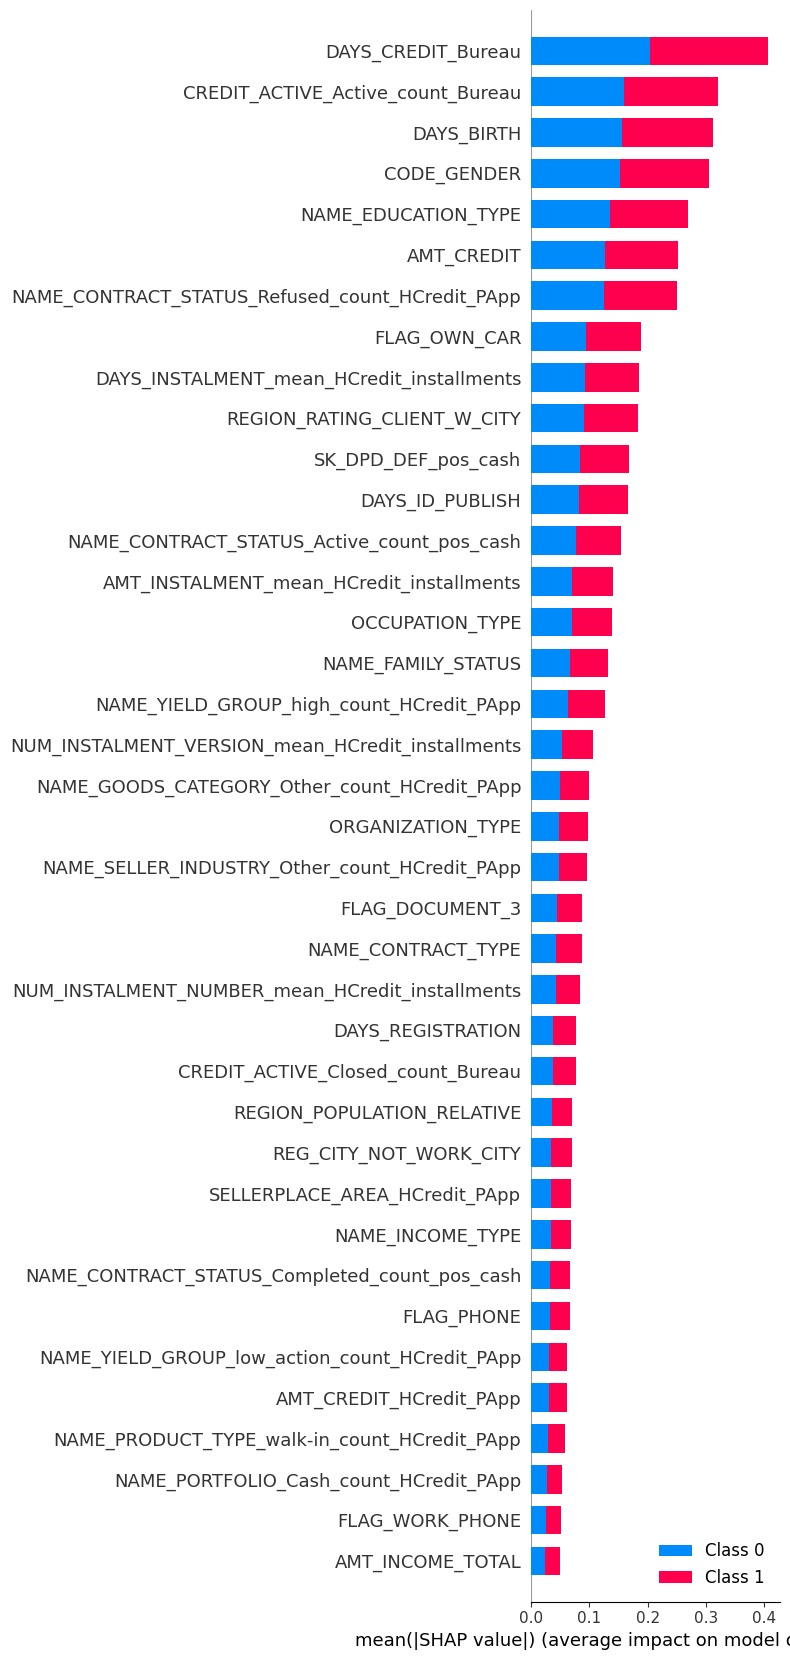

In [72]:
explainer5 = shap.TreeExplainer(LGB_model5)


shap_values = explainer5.shap_values(X_val)
shap.initjs()

shap.summary_plot(shap_values, X_val, max_display=len(X_val.columns), plot_type='bar') 
plt.show()

In [73]:
X_val

AMT_INCOME_TOTAL  AMT_CREDIT  REGION_POPULATION_RELATIVE  \
31960           121500.0    254700.0                    0.004849   
136880          157500.0   1078200.0                    0.018634   
197022          112500.0    270000.0                    0.018850   
289571          292500.0    519633.0                    0.010006   
185566          225000.0    225000.0                    0.018029   
...                  ...         ...                         ...   
156524          166500.0    337500.0                    0.005313   
186552          135000.0    192874.5                    0.018029   
82733           540000.0    450000.0                    0.046220   
150752          180000.0   1051245.0                    0.010147   
35823           112500.0    180000.0                    0.010032   

        DAYS_REGISTRATION  DAYS_BIRTH  DAYS_ID_PUBLISH  FLAG_WORK_PHONE  \
31960             -7139.0      -24099            -4208                0   
136880            -3589.0      -13300            -4313                1   
197022            -6513.0       -9351            -2005                0   
289571              -86.0      -15222            -4210                0   
185566            -8830.0      -16226            -4712                0   
...                   ...         ...              ...              ...   
156524            -7410.0      -19391            -2944                0   
186552             -821.0      -10450            -2613                1   
82733             -2071.0      -19663            -1082                0   
150752           -10143.0      -13583            -4490                0   
35823             -4873.0      -11173            -3431                0   

        FLAG_PHONE  REGION_RATING_CLIENT_W_CITY  REG_CITY_NOT_WORK_CITY  ...  \
31960            0                            2                       0  ...   
136880           1                            2                       1  ...   
197022           1                            2                       0  ...   
289571           0                            1                       0  ...   
185566           0                            3                       0  ...   
...            ...                          ...                     ...  ...   
156524           0                            2                       0  ...   
186552           0                            3                       0  ...   
82733            0                            1                       1  ...   
150752           0                            2                       0  ...   
35823            0                            2                       0  ...   

        SK_DPD_DEF_pos_cash NAME_CONTRACT_STATUS_Refused_count_HCredit_PApp  \
31960                   0.0                                             0.0   
136880                  0.0                                             0.0   
197022                  0.0                                             2.0   
289571                  0.0                                             1.0   
185566                  0.0                                             0.0   
...                     ...                                             ...   
156524                  0.0                                             2.0   
186552                  0.0                                             9.0   
82733                   NaN                                             NaN   
150752                  0.0                                             1.0   
35823                   0.0                                             0.0   

       NAME_GOODS_CATEGORY_Other_count_HCredit_PApp  \
31960                                           1.0   
136880                                          0.0   
197022                                          5.0   
289571                                          2.0   
185566                                          1.0   
...                                             ..

In [74]:
train_columns = X_train.columns.tolist()

In [75]:
train_columns.append("TARGET")

In [76]:
train_columns

['AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'REGION_POPULATION_RELATIVE',
 'DAYS_REGISTRATION',
 'DAYS_BIRTH',
 'DAYS_ID_PUBLISH',
 'FLAG_WORK_PHONE',
 'FLAG_PHONE',
 'REGION_RATING_CLIENT_W_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'FLAG_DOCUMENT_3',
 'NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'OCCUPATION_TYPE',
 'ORGANIZATION_TYPE',
 'CREDIT_ACTIVE_Active_count_Bureau',
 'CREDIT_ACTIVE_Closed_count_Bureau',
 'DAYS_CREDIT_Bureau',
 'AMT_INSTALMENT_mean_HCredit_installments',
 'DAYS_INSTALMENT_mean_HCredit_installments',
 'NUM_INSTALMENT_NUMBER_mean_HCredit_installments',
 'NUM_INSTALMENT_VERSION_mean_HCredit_installments',
 'NAME_CONTRACT_STATUS_Active_count_pos_cash',
 'NAME_CONTRACT_STATUS_Completed_count_pos_cash',
 'SK_DPD_DEF_pos_cash',
 'NAME_CONTRACT_STATUS_Refused_count_HCredit_PApp',
 'NAME_GOODS_CATEGORY_Other_count_HCredit_PApp',
 'NAME_PORTFOLIO_Cash_count_HCredit_PApp',
 'NAME_PRODUCT_TYPE_walk-in_count_HC

In [77]:
df_main1 = df_main

In [78]:
df_main1 = df_main1.set_index('SK_ID_CURR')

In [79]:
df_main1 = df_main1[train_columns]

In [80]:
df_main1 = df_main1.reset_index()

In [81]:
df_main1.head(5)

SK_ID_CURR  AMT_INCOME_TOTAL  AMT_CREDIT  REGION_POPULATION_RELATIVE  \
0      100002          202500.0    406597.5                    0.018801   
1      100003          270000.0   1293502.5                    0.003541   
2      100004           67500.0    135000.0                    0.010032   
3      100006          135000.0    312682.5                    0.008019   
4      100007          121500.0    513000.0                    0.028663   

   DAYS_REGISTRATION  DAYS_BIRTH  DAYS_ID_PUBLISH  FLAG_WORK_PHONE  \
0            -3648.0       -9461            -2120                0   
1            -1186.0      -16765             -291                0   
2            -4260.0      -19046            -2531                1   
3            -9833.0      -19005            -2437                0   
4            -4311.0      -19932            -3458                0   

   FLAG_PHONE  REGION_RATING_CLIENT_W_CITY  ...  \
0           1                            2  ...   
1           1                            1  ...   
2           1                            2  ...   
3           0                            2  ...   
4           0                            2  ...   

   NAME_CONTRACT_STATUS_Refused_count_HCredit_PApp  \
0                                              0.0   
1                                              0.0   
2                                              0.0   
3                                              1.0   
4                                              0.0   

   NAME_GOODS_CATEGORY_Other_count_HCredit_PApp  \
0                                           1.0   
1                                           2.0   
2                                           0.0   
3                                           2.0   
4                                           2.0   

  NAME_PORTFOLIO_Cash_count_HCredit_PApp  \
0                                    0.0   
1                                    1.0   
2                                    0.0   
3                                    3.0   
4                                    4.0   

  NAME_PRODUCT_TYPE_walk-in_count_HCredit_PApp  \
0                                          0.0   
1                                          0.0   
2                                          0.0   
3                                          0.0   
4                                          1.0   

   NAME_SELLER_INDUSTRY_Other_count_HCredit_PApp  \
0                                            1.0   
1                                            1.0   
2                                            0.0   
3                                            1.0   
4                                            0.0   

  NAME_YIELD_GROUP_high_count_HCredit_PApp  \
0                                      0.0   
1                                      0.0   
2                                      0.0   
3                                      2.0   
4                                      3.0   

  NAME_YIELD_GROUP_low_action_count_HCredit_PApp AMT_CREDIT_HCredit_PApp  \
0                                            0.0               179055.00   
1                                            0.0               484191.00   
2                                            0.0                20106.00   
3                                            0.0               291695.50   
4                                            0.0               166638.75   

  SELLERPLACE_AREA_HCredit_PApp TARGET  
0                    500.000000      1  
1                    533.000000      0  
2                     30.000000      0  
3                    894.222222      0  
4                    409.166667      0  

[5 rows x 40 columns]

In [82]:
df_main1.to_csv("post_modelling_data.csv",index=False)

# Recursive features addition for indication of smallest amount of features for good predictions and which features would be in. 

In [83]:
tr = RecursiveFeatureAddition(estimator=LGB_model5, scoring="recall_macro", cv=3)


In [84]:
Xt = tr.fit_transform(X, y)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 13251, number of negative: 150755
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.211221 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6776
[LightGBM] [Info] Number of data points in the train set: 164006, number of used features: 90
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080796 -> initscore=-2.431583
[LightGBM] [Info] Start training from score -2.431583
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 13251, number of negative: 150755
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.084713 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6770
[LightGBM] [

[LightGBM] [Info] Number of positive: 13251, number of negative: 150755
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011056 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 164006, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080796 -> initscore=-2.431583
[LightGBM] [Info] Start training from score -2.431583
[LightGBM] [Info] Number of positive: 13250, number of negative: 150756
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008049 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 164006, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080790 -> initscore=-2.431665
[LightGBM] [Info] Start training from score -2.431665
[LightGBM]

[LightGBM] [Info] Number of positive: 13251, number of negative: 150755
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005620 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 785
[LightGBM] [Info] Number of data points in the train set: 164006, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080796 -> initscore=-2.431583
[LightGBM] [Info] Start training from score -2.431583
[LightGBM] [Info] Number of positive: 13251, number of negative: 150755
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001882 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 786
[LightGBM] [Info] Number of data points in the train set: 164006, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080796 -> initscore=-2.431583
[L

[LightGBM] [Info] Number of positive: 13251, number of negative: 150755
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002047 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 164006, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080796 -> initscore=-2.431583
[LightGBM] [Info] Start training from score -2.431583
[LightGBM] [Info] Number of positive: 13250, number of negative: 150756
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005995 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 164006, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080790 -> initscore=-2.431665


[LightGBM] [Info] Number of positive: 13250, number of negative: 150756
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001979 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 800
[LightGBM] [Info] Number of data points in the train set: 164006, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080790 -> initscore=-2.431665
[LightGBM] [Info] Start training from score -2.431665
[LightGBM] [Info] Number of positive: 13251, number of negative: 150755
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006008 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 164006, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080796 -> initscore=-2.431583
[

[LightGBM] [Info] Number of positive: 13251, number of negative: 150755
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002139 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 769
[LightGBM] [Info] Number of data points in the train set: 164006, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080796 -> initscore=-2.431583
[LightGBM] [Info] Start training from score -2.431583
[LightGBM] [Info] Number of positive: 13251, number of negative: 150755
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001817 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 769
[LightGBM] [Info] Number of data points in the train set: 164006, number of used features: 4
[LightGBM] [Info] 

[LightGBM] [Info] Number of positive: 13251, number of negative: 150755
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001740 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 164006, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080796 -> initscore=-2.431583
[LightGBM] [Info] Start training from score -2.431583
[LightGBM] [Info] Number of positive: 13250, number of negative: 150756
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002316 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 164006, number of used features: 4
[LightGBM] [Info

[LightGBM] [Info] Number of positive: 13251, number of negative: 150755
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006132 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 789
[LightGBM] [Info] Number of data points in the train set: 164006, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080796 -> initscore=-2.431583
[LightGBM] [Info] Start training from score -2.431583
[LightGBM] [Info] Number of positive: 13250, number of negative: 150756
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008510 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 788
[LightGBM] [Info] Number of data points in the train set: 164006, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080790 -> initscore=-2.431665
[LightGBM] [Info] Start training from score -2.431665
[LightGBM] [

[LightGBM] [Info] Number of positive: 13250, number of negative: 150756
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001861 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 796
[LightGBM] [Info] Number of data points in the train set: 164006, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080790 -> initscore=-2.431665
[LightGBM] [Info] Start training from score -2.431665
[LightGBM] [Info] Number of positive: 13251, number of negative: 150755
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001957 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 767
[LightGBM] [Info] Number of data points in the train set: 164006, number of used features: 4
[LightGBM] [Info] 

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 13251, number of negative: 150755
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005659 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 795
[LightGBM] [Info] Number of data points in the train set: 164006, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080796 -> initscore=-2.431583
[LightGBM] [Info] Start training from score -2.431583
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 13251, number of negative: 150755
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001894 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 794
[LightGBM] [Inf

[LightGBM] [Info] Number of positive: 13251, number of negative: 150755
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004064 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 786
[LightGBM] [Info] Number of data points in the train set: 164006, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080796 -> initscore=-2.431583
[LightGBM] [Info] Start training from score -2.431583
[LightGBM] [Info] Number of positive: 13250, number of negative: 150756
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004133 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 787
[LightGBM] [Info] Number of data points in the train set: 164006, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080790 -> initscore=-2.431665
[LightGBM] [Info] Start training from score -2.431665
[LightGBM] [

[LightGBM] [Info] Number of positive: 13250, number of negative: 150756
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008879 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 772
[LightGBM] [Info] Number of data points in the train set: 164006, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080790 -> initscore=-2.431665
[LightGBM] [Info] Start training from score -2.431665
[LightGBM] [Info] Number of positive: 13251, number of negative: 150755
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049049 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 785
[LightGBM] [Info] Number of data points in the train set: 164006, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080796 -> initscore=-2.431583
[L

[LightGBM] [Info] Number of positive: 13251, number of negative: 150755
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007265 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 790
[LightGBM] [Info] Number of data points in the train set: 164006, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080796 -> initscore=-2.431583
[LightGBM] [Info] Start training from score -2.431583
[LightGBM] [Info] Number of positive: 13251, number of negative: 150755
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009181 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 789
[LightGBM] [Info] Number of data points in the train set: 164006, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080796 -> initscore=-2.431583
[LightGBM] [Info] Start training from score -2.431583
[LightGBM] [

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 13251, number of negative: 150755
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005386 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 784
[LightGBM] [Info] Number of data points in the train set: 164006, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080796 -> initscore=-2.431583
[LightGBM] [Info] Start training from score -2.431583
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 13250, number of negative: 150756
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016763 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 783
[LightGBM] [Info] Number of data points in the train set: 164006, number of use

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 13251, number of negative: 150755
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006171 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 785
[LightGBM] [Info] Number of data points in the train set: 164006, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080796 -> initscore=-2.431583
[LightGBM] [Info] Start training from score -2.431583
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 13250, number of negative: 150756
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009746 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 785
[LightGBM] [Info] Number of data points in the train set: 164006, number of use

[LightGBM] [Info] Number of positive: 13251, number of negative: 150755
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002311 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 767
[LightGBM] [Info] Number of data points in the train set: 164006, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080796 -> initscore=-2.431583
[LightGBM] [Info] Start training from score -2.431583
[LightGBM] [Info] Number of positive: 13251, number of negative: 150755
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006925 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 767
[LightGBM] [Info] Number of data points in the train set: 164006, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080796 -> initscore=-2.431583
[L

[LightGBM] [Info] Number of positive: 13251, number of negative: 150755
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002757 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 767
[LightGBM] [Info] Number of data points in the train set: 164006, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080796 -> initscore=-2.431583
[LightGBM] [Info] Start training from score -2.431583
[LightGBM] [Info] Number of positive: 13250, number of negative: 150756
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002773 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 767
[LightGBM] [Info] Number of data points in the train set: 164006, number of used features: 4
[LightGBM] [Info] 

[LightGBM] [Info] Number of positive: 13251, number of negative: 150755
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002390 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 770
[LightGBM] [Info] Number of data points in the train set: 164006, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080796 -> initscore=-2.431583
[LightGBM] [Info] Start training from score -2.431583
[LightGBM] [Info] Number of positive: 13250, number of negative: 150756
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005319 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 769
[LightGBM] [Info] Number of data points in the train set: 164006, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080790 -> initscore=-2.431665
[L

In [85]:
tr.initial_model_performance_

0.6479125046696873

In [86]:
tr.performance_drifts_

{'AMT_CREDIT': 0,
 'DAYS_BIRTH': 0.016676334972581364,
 'DAYS_CREDIT_Bureau': 0.018773057717514474,
 'NUM_INSTALMENT_VERSION_mean_HCredit_installments': 0.006500315936545098,
 'AMT_INSTALMENT_mean_HCredit_installments': 0.0031272635870366328,
 'DAYS_ID_PUBLISH': -0.00018966106597129162,
 'NUM_INSTALMENT_NUMBER_mean_HCredit_installments': 0.0018202226756711681,
 'DAYS_REGISTRATION': -0.0010815411617624004,
 'DAYS_DECISION_HCredit_PApp': 0.001696456116188405,
 'REGION_POPULATION_RELATIVE': 0.007048877074616211,
 'CREDIT_ACTIVE_Active_count_Bureau': 0.008074502538197859,
 'DAYS_CREDIT_UPDATE_Bureau': -0.0008144746380798207,
 'DAYS_INSTALMENT_mean_HCredit_installments': 0.00216287846257468,
 'NAME_CONTRACT_STATUS_Active_count_pos_cash': 0.0030934622604300577,
 'SELLERPLACE_AREA_HCredit_PApp': 0.0033155803618083457,
 'MONTHS_BALANCE_pos_cash': 0.002009018112355321,
 'AMT_APPLICATION_HCredit_PApp': 0.0008834961804888852,
 'AMT_CREDIT_HCredit_PApp': 0.0020907785186712324,
 'AMT_INCOME_TOTAL':

In [87]:
tr.features_to_drop_

['AMT_INCOME_TOTAL',
 'REGION_POPULATION_RELATIVE',
 'DAYS_REGISTRATION',
 'CNT_CHILDREN',
 'DAYS_ID_PUBLISH',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_PHONE',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'FLAG_DOCUMENT_2',
 'FLAG_DOCUMENT_3',
 'FLAG_DOCUMENT_6',
 'FLAG_DOCUMENT_8',
 'FLAG_DOCUMENT_9',
 'FLAG_DOCUMENT_11',
 'FLAG_DOCUMENT_13',
 'FLAG_DOCUMENT_14',
 'FLAG_DOCUMENT_15',
 'FLAG_DOCUMENT_16',
 'FLAG_DOCUMENT_18',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CREDIT_ACTIVE_Active_count_Bureau',
 'CREDIT_ACTIVE_Closed_count_Bureau',
 'CREDIT_ACTIVE_Sold_count_Bureau',
 'CREDIT_CURRENCY_currency 1_count_Bureau',
 'CREDIT_TYPE_Consumer credit_count_Bureau',
 'CREDIT_TYPE_Credit card_count_Bureau',
 'CREDIT_TYPE_Other_count_Bureau',
 'CREDIT_DAY_OVERDUE_Bureau',
 'CNT_CREDIT_PROLONG_Bureau',
 'AMT_

In [88]:
Xt.head()

AMT_CREDIT  DAYS_BIRTH NAME_CONTRACT_TYPE CODE_GENDER NAME_TYPE_SUITE  \
1   1293502.5      -16765         Cash loans           F          Family   
3    312682.5      -19005         Cash loans           F   Unaccompanied   
4    513000.0      -19932         Cash loans           M   Unaccompanied   
5    490495.5      -16941         Cash loans           M           Other   
7   1530000.0      -18850         Cash loans           M   Unaccompanied   

  NAME_INCOME_TYPE            NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  \
1            Other               Higher education               Married   
3          Working  Secondary / secondary special        Civil marriage   
4          Working  Secondary / secondary special  Single / not married   
5            Other  Secondary / secondary special               Married   
7            Other               Higher education               Married   

   NAME_HOUSING_TYPE OCCUPATION_TYPE WEEKDAY_APPR_PROCESS_START  \
1  House / apartment      Core staff                     MONDAY   
3  House / apartment        Laborers                  WEDNESDAY   
4  House / apartment      Core staff                   THURSDAY   
5  House / apartment        Laborers                  WEDNESDAY   
7  House / apartment        Managers                     MONDAY   

        ORGANIZATION_TYPE  DAYS_CREDIT_Bureau  
1                   Other        -1400.750000  
3  Business Entity Type 3                 NaN  
4                   Other        -1149.000000  
5                   Other         -757.333333  
7                   Other        -1939.500000

In [89]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3,stratify=y, random_state=42)
LGB_model6 = LGBMClassifier(
    scale_pos_weight=11,
    objective='binary',
    boosting_type='gbdt',
    metric='auc_pr'
)

LGB_model6.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)], 
)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 13913, number of negative: 158293
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.067053 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6833
[LightGBM] [Info] Number of data points in the train set: 172206, number of used features: 100
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080793 -> initscore=-2.431624
[LightGBM] [Info] Start training from score -2.431624


LGBMClassifier(metric='auc_pr', objective='binary', scale_pos_weight=11)

In [91]:
y_pred = LGB_model6.predict(X_val)

# Obtain the classification report
class_report6 = classification_report(y_val, y_pred)
print(class_report6)

              precision    recall  f1-score   support

           0       0.95      0.71      0.81     67840
           1       0.16      0.61      0.25      5963

    accuracy                           0.70     73803
   macro avg       0.56      0.66      0.53     73803
weighted avg       0.89      0.70      0.77     73803



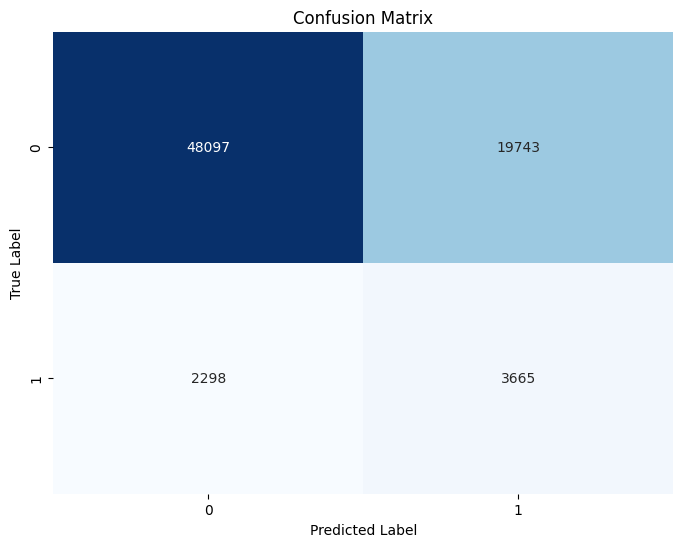

In [92]:
conf_matrix = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [93]:
sig_features = list(Xt.columns)

sig_features.append("TARGET")

sig_features

['AMT_CREDIT',
 'DAYS_BIRTH',
 'NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'ORGANIZATION_TYPE',
 'DAYS_CREDIT_Bureau',
 'TARGET']

In [94]:
df_main2 = df_main.copy()

In [95]:
df_main2 = df_main2.set_index('SK_ID_CURR')
df_main2 = df_main2[sig_features]

In [96]:
df_main2 = df_main2.reset_index()

In [97]:
df_main2

SK_ID_CURR  AMT_CREDIT  DAYS_BIRTH NAME_CONTRACT_TYPE CODE_GENDER  \
0           100002    406597.5       -9461         Cash loans           M   
1           100003   1293502.5      -16765         Cash loans           F   
2           100004    135000.0      -19046    Revolving loans           M   
3           100006    312682.5      -19005         Cash loans           F   
4           100007    513000.0      -19932         Cash loans           M   
...            ...         ...         ...                ...         ...   
307506      456251    254700.0       -9327         Cash loans           M   
307507      456252    269550.0      -20775         Cash loans           F   
307508      456253    677664.0      -14966         Cash loans           F   
307509      456254    370107.0      -11961         Cash loans           F   
307510      456255    675000.0      -16856         Cash loans           F   

       NAME_TYPE_SUITE      NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
0        Unaccompanied               Working  Secondary / secondary special   
1               Family                 Other               Higher education   
2        Unaccompanied               Working  Secondary / secondary special   
3        Unaccompanied               Working  Secondary / secondary special   
4        Unaccompanied               Working  Secondary / secondary special   
...                ...                   ...                            ...   
307506   Unaccompanied               Working  Secondary / secondary special   
307507   Unaccompanied             Pensioner  Secondary / secondary special   
307508   Unaccompanied               Working               Higher education   
307509   Unaccompanied  Commercial associate  Secondary / secondary special   
307510   Unaccompanied  Commercial associate               Higher education   

          NAME_FAMILY_STATUS  NAME_HOUSING_TYPE OCCUPATION_TYPE  \
0       Single / not married  House / apartment        Laborers   
1                    Married  House / apartment      Core staff   
2       Single / not married  House / apartment        Laborers   
3             Civil marriage  House / apartment        Laborers   
4       Single / not married  House / apartment      Core staff   
...                      ...                ...             ...   
307506                 Other       With parents     Sales staff   
307507                 Other  House / apartment           Other   
307508                 Other  House / apartment        Managers   
307509               Married  House / apartment        Laborers   
307510               Married  House / apartment        Laborers   

       WEEKDAY_APPR_PROCESS_START       ORGANIZATION_TYPE  DAYS_CREDIT_Bureau  \
0                       WEDNESDAY  Business Entity Type 3         -874.000000   
1                          MONDAY                   Other        -1400.750000   
2                          MONDAY                   Other         -867.000000   
3                       WEDNESDAY  Business Entity Type 3                 NaN   
4                        THURSDAY                   Other        -1149.000000   
...                           ...                     ...                 ...   
307506                   THURSDAY                   Other                 NaN   
307507                     MONDAY                     XNA                 NaN   
307508                   THURSDAY                   Other         -867.500000   
307509                  WEDNESDAY                   Other        -1104.000000   
307510                   THURSDAY  Business Entity Type 3        -1089.454545   

        TARGET  
0            1  
1            0  
2            0  
3            0  
4            0  
...        ...  
307506       0  
307507       0  
307508       0  
307509       1  
307510       0  

[307511 rows x 15 columns]

In [98]:
df_main2.to_csv("post_modelling_RFA_data.csv",index=False)

In [100]:
df_main1

SK_ID_CURR  AMT_INCOME_TOTAL  AMT_CREDIT  REGION_POPULATION_RELATIVE  \
0           100002          202500.0    406597.5                    0.018801   
1           100003          270000.0   1293502.5                    0.003541   
2           100004           67500.0    135000.0                    0.010032   
3           100006          135000.0    312682.5                    0.008019   
4           100007          121500.0    513000.0                    0.028663   
...            ...               ...         ...                         ...   
307506      456251          157500.0    254700.0                    0.032561   
307507      456252           72000.0    269550.0                    0.025164   
307508      456253          153000.0    677664.0                    0.005002   
307509      456254          171000.0    370107.0                    0.005313   
307510      456255          157500.0    675000.0                    0.046220   

        DAYS_REGISTRATION  DAYS_BIRTH  DAYS_ID_PUBLISH  FLAG_WORK_PHONE  \
0                 -3648.0       -9461            -2120                0   
1                 -1186.0      -16765             -291                0   
2                 -4260.0      -19046            -2531                1   
3                 -9833.0      -19005            -2437                0   
4                 -4311.0      -19932            -3458                0   
...                   ...         ...              ...              ...   
307506            -8456.0       -9327            -1982                0   
307507            -4388.0      -20775            -4090                0   
307508            -6737.0      -14966            -5150                0   
307509            -2562.0      -11961             -931                0   
307510            -5128.0      -16856             -410                1   

        FLAG_PHONE  REGION_RATING_CLIENT_W_CITY  ...  \
0                1                            2  ...   
1                1                            1  ...   
2                1                            2  ...   
3                0                            2  ...   
4                0                            2  ...   
...            ...                          ...  ...   
307506           0                            1  ...   
307507           1                            2  ...   
307508           0                            3  ...   
307509           0                            2  ...   
307510           1                            1  ...   

        NAME_CONTRACT_STATUS_Refused_count_HCredit_PApp  \
0                                                   0.0   
1                                                   0.0   
2                                                   0.0   
3                                                   1.0   
4                                                   0.0   
...                                                 ...   
307506                                              0.0   
307507                                              0.0   
307508                                              0.0   
307509                                              0.0   
307510                                              2.0   

        NAME_GOODS_CATEGORY_Other_count_HCredit_PApp  \
0                                                1.0   
1                                                2.0   
2                                                0.0   
3                                                2.0   
4                                                2.0   
...                                              ...   
307506                                           0.0   
307507                                           1.0   
307508                                           0.0   
307509                                           1.0   
307510                                           2.0   

       NAME_PORTFOLIO_Cash_count_HCredit_PApp  \
0                                         